# Scheduling benchmarks analysis

## Library

In [2]:
import matplotlib.pyplot as plt
from typing import Optional, List
import pandas as pd
import os
import re
import json
import PyQt5

#### Cache

In [3]:
TRACE_CMD_CACHE_FILENAME = "trace_cmd_runtimes"
RESULTS_DIR_PATH = "../results"

def get_result_dir_path(result_dir_name):
    return os.path.join(RESULTS_DIR_PATH, result_dir_name)

# cache_dir = os.path.join(results_dir, "cache")
# if not os.path.exists(cache_dir) :
#     os.makedirs(cache_dir, exist_ok = True)

# def load_cache() :
#     cache_files = sorted([file for file in os.listdir(cache_dir) if file.endswith('.csv')])
#     for filename in cache_files:
#         cache[filename] = pd.read_csv(os.path.join(cache_dir, filename))

# def save_cache() :
#     for key, value in cache.items() :
#         value.to_csv(file_name, encoding='utf-8', index=False)

#### Trace-cmd results processing functions

TODO : Find out if it wouldn't be faster to just extract dat files in memory instead of having to extract them beforehand

In [4]:
def extract_timestamp(line) -> Optional[float] :
    match = re.search(r'\s+(\d+\.\d+):', line)
    if match:
        return float(match.group(1))
    return None


def get_run_index(filename) -> int :
    match = re.search(r'_(\d+)\.log', filename)
    if match:
        return int(match.group(1))
    return None


def get_duration(log_file_path) :
    last_line = ""
    first_timestamp = None
    with open(log_file_path, 'r') as file :
        for line in file :
            if first_timestamp is None :
                first_timestamp = extract_timestamp(line)
            last_line = line
    last_timestamp = extract_timestamp(last_line)
    return last_timestamp - first_timestamp


# Expects a complete path as directory
def get_runtimes_dataframe(directory) :
    if not os.path.exists(directory) :
        # print(f"get_runtimes_dataframe : directory {directory} not found, skipping")
        return None

    cache_path = os.path.join(directory, TRACE_CMD_CACHE_FILENAME + "runtimes.csv")
    if os.path.isfile(cache_path):
        df = pd.read_csv(cache_path)
    else :
        dat_files = [file for file in os.listdir(directory) if file.endswith('.dat')]
        log_files = [file for file in os.listdir(directory) if file.endswith('.log')]
    
        ndat = len(dat_files)
        nlog = len(log_files)
        if ndat > 0 :
            if nlog == 0 :
                print(f"get_runtimes_dataframe : none of the {ndat} trace files contained in {directory} have been extracted. Run extract_all_dat_traces beforehand.")
                return None
            elif nlog != ndat :
                print(f"get_runtimes_dataframe : WARNING - only {nlog} of the {ndat} trace files contained in {directory} have been extracted. Consider running extract_all_dat_traces.")
        elif nlog == 0 :
            print(f"get_runtimes_dataframe : no trace files found in {directory}, skipping")
            return None
        
        df = pd.DataFrame({'filename': log_files})
        df['filepath'] = df['filename'].map(lambda x: os.path.join(directory, x))
        df['duration'] = df['filepath'].map(get_duration)
        df.sort_values('duration', ignore_index=True, inplace=True)

        df.to_csv(cache_path, encoding='utf-8', index=False)

    min_duration = df['duration'][0]
    df['variation'] = (df['duration'] - df['duration'][0]) * 100 / df['duration'][0]
    return df

#### Visualization functions

In [20]:
test = [0, 2, 6]
[0.3] + list(range(len(test)))

[0.3, 0, 1, 2]

In [59]:
# Naming convention :
# - run : 1 set of files, either nb or no_nb
# - benchmark / result : 1 series of nb and 1 series of no_nb

nb_enabled_color = "tab:orange"
nb_disabled_color = "tab:blue"

figure_height = 10

def init_runtimes_plot():
    # plt.figure(figsize=(fig_width, 5))
    # plt.legend(loc="upper left")
    plt.xlabel("Nth run")
    plt.ylabel("Run time (seconds)")
    plt.grid(axis="y", which="both")
    plt.grid(axis="x", which="major")
    
    # ax = plt.gca()
    # ax.ticklabel_format(axis="x", useOffset=1.0)
    

def plot_hyperfine_run(times: List[float], label = None, color = None, init_plot = True):
    if init_plot:
        init_runtimes_plot()
    # plt.figure(figsize=(50, 5))
    plt.plot(range(len(times)), times, label = label, color = color)
    
    current_xticks_count = len(plt.xticks()[0])
    if len(times) > current_xticks_count :
        # plt.xticks([-0.25] + list(range(len(times))), rotation=45)
        plt.xticks(range(len(times)), rotation=45)
        plt.xlim(-1, len(times))
        
    # plt.legend(loc="upper left")
    # plt.ylabel("Run time (seconds)")
    
    # plt.xlabel("Nth run")
    # plt.grid(axis="y", which="both")
    # plt.grid(axis="x", which="major")
    
    candidate_ylim_max = max(times) * 1.2
    if candidate_ylim_max > plt.ylim()[1] :
        plt.ylim(0, candidate_ylim_max)
        
    # ax = plt.gca()
    # ax.ticklabel_format(axis="x", useOffset=1)
    
    fig = plt.gcf()
    candidate_width = int(len(times) / 4)
    curr_width = fig.get_size_inches()[0]
    if candidate_width > curr_width :
        fig.set_size_inches(candidate_width, figure_height)
    
    if label :
        plt.legend(loc="upper left")
    
    
def plot_hyperfine_benchmark(times_nb: List[float], times_no_nb: List[float], benchmark_name: str, sort_values = True) :
    if sort_values:
        times_nb.sort()
        times_no_nb.sort()
        
    init_runtimes_plot()
    if times_nb :
        plot_hyperfine_run(times_nb, benchmark_name + " | NB enabled", nb_enabled_color, False)
    if times_no_nb :
        plot_hyperfine_run(times_no_nb, benchmark_name + " | NB disabled", nb_disabled_color, False)
    plot_title = benchmark_name + " sorted" if sort_values else " unsorted"
    plt.title(plot_title)
    # plt.legend()
    plt.show()
    

def plot_trace_cmd_runtimes(df_nb, df_no_nb, benchmark_name, show_run_index = True, fig_width = 12) :
    if df_nb is None and df_no_nb is None :
        print("plot_trace_cmd_runtimes : ERROR - both with and without NUMA balancing data frames are None")
        return
        
    plt.figure(figsize=(fig_width, 5))

    df_nb_index_len = 0
    df_no_nb_index_len = 0
    max_val = 0
    if df_nb is not None :
        plt.plot(df_nb.index, df_nb['duration'], label = "With NUMA balancing - Run index", color="tab:orange")
        df_nb_index_len = len(df_nb.index)
        max_val = max(df_nb['duration'])
    if df_no_nb is not None :
        plt.plot(df_no_nb.index, df_no_nb['duration'], label = "Without NUMA balancing - Run index", color="tab:blue")
        max_val = max(max_val, max(df_no_nb['duration']))
    plt.xticks(range(max(df_nb_index_len, df_no_nb_index_len)))

    
    plt.legend(loc="upper left")
    plt.ylabel("Run time (seconds)")

    xlabel_str = "Nth slowest run"
    if show_run_index :
        xlabel_str += ". The actual run index is on the lines"
    plt.xlabel(xlabel_str)
    plt.title(benchmark_name)
    plt.grid(axis="y", which="both")
    plt.grid(axis="x", which="major")
    
    ax = plt.gca()
    ax.set_ylim(0, max_val * 1.2)
    ax.ticklabel_format(axis="x", useOffset=1.0)
    plt.xticks(rotation=45)

    if show_run_index :
        if df_nb is not None :
            for idx in df_nb.index:
                ax.text(idx, df_nb['duration'][idx], get_run_index(df_nb['filename'][idx]), fontsize=8)
        if df_no_nb is not None :
            for idx in df_no_nb.index:
                ax.text(idx, df_no_nb['duration'][idx], get_run_index(df_no_nb['filename'][idx]), fontsize=8)

    # plt.minorticks_on()
    plt.show()

#### Summary functions

In [6]:
def show_results_for(parent_directory, show_run_index = True, fig_width = 28) :
    df_nb = get_runtimes_dataframe(os.path.join(parent_directory, "nb"))
    # if df_nb is None :
    #     print(f"ERROR : no runs dataframe retrieved for directory {parent_directory}/nb")
    #     return
    
    df_no_nb = get_runtimes_dataframe(os.path.join(parent_directory, "no_nb"))
    # if df_no_nb is None :
    #     print(f"ERROR : no runs dataframe retrieved for directory {parent_directory}/no_nb")
    #     return

    plot_trace_cmd_runtimes(df_nb, df_no_nb, parent_directory, show_run_index, fig_width)

## Experiments

#### Available results
Trace cmd results - `.dat` files - are expected to be located in the `./results` directory. \
They are also expected to have been extracted to plain text `.log` files using the shell function `extract_all_dat_traces`

In [49]:
benchmarks_dirs = sorted([dir for dir in os.listdir(RESULTS_DIR_PATH) if os.path.isdir(get_result_dir_path(dir))])

def get_hyperfine_runtimes(run_dir_path) -> List[float]:
    hyperfine_run_files = [file for file in os.listdir(run_dir_path) if file.endswith(".json")]
    if len(hyperfine_run_files) == 0 :
        return []
    if len(hyperfine_run_files) > 1 :
        print("WARNING : More than 1 hyperfine run files found in", run_dir_path)
    
    with open(os.path.join(run_dir_path, hyperfine_run_files[0])) as f:
        data = json.load(f)
    return data['results'][0]['times']

def get_run_dir_description(run_dir_path: str):
    n_trace_files = len([file for file in os.listdir(run_dir_path) if file.endswith('.dat')])
    hyperfine_runtimes = get_hyperfine_runtimes(run_dir_path)
    result = ""
    separator = ""
    if n_trace_files > 0 :
        result += f"{n_trace_files} trace-cmd runs"
        separator = ', '
    if len(hyperfine_runtimes) > 0 :
        result += separator + f"{len(hyperfine_runtimes)} hyperfine runs"
    return result

# TODO Sort by trace and hyperfine
for dir_name in benchmarks_dirs :
    dir_path = get_result_dir_path(dir_name)
    nb_dir_path = os.path.join(dir_path, "nb")
    no_nb_dir_path = os.path.join(dir_path, "no_nb")
    
    line = f"{dir_name}"
    if os.path.exists(nb_dir_path) :
        line += f" | NB enabled : {get_run_dir_description(nb_dir_path)}"
    if os.path.exists(no_nb_dir_path) :
        line += f" | NB enabled : {get_run_dir_description(no_nb_dir_path)}"
    print(line)
    
    

bt.B.dahu-17.v6.8-rc3 | NB enabled : 200 trace-cmd runs | NB enabled : 200 trace-cmd runs
bt.B.servan-1.v6.8-rc3 | NB enabled : 200 hyperfine runs | NB enabled : 200 hyperfine runs
bt.C.dahu-28.v6.8-rc3 | NB enabled : 100 trace-cmd runs | NB enabled : 100 trace-cmd runs
bt.C.dahu.v6.1.0-17 | NB enabled : 50 trace-cmd runs
bt.C.servan-1.v6.8-rc3 | NB enabled : 200 hyperfine runs | NB enabled : 200 hyperfine runs
bt.C.yeti.v6.1.0-17 | NB enabled : 50 trace-cmd runs | NB enabled : 10 trace-cmd runs
cg.C.servan-1.v6.8-rc3 | NB enabled : 200 trace-cmd runs | NB enabled : 200 trace-cmd runs
cg.C.servan-2.v6.1.0-17 | NB enabled : 100 trace-cmd runs | NB enabled : 100 trace-cmd runs
cg.C.servan.v6.1.0-17 | NB enabled : 20 trace-cmd runs | NB enabled : 10 trace-cmd runs
ep.D.dahu.v6.1.0-17 | NB enabled : 100 trace-cmd runs | NB enabled : 100 trace-cmd runs
ft.C.dahu.v6.1.0-17 | NB enabled : 100 trace-cmd runs | NB enabled : 100 trace-cmd runs
ft.C.yeti-1.v6.1.0-17 | NB enabled : 100 trace-cmd r

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


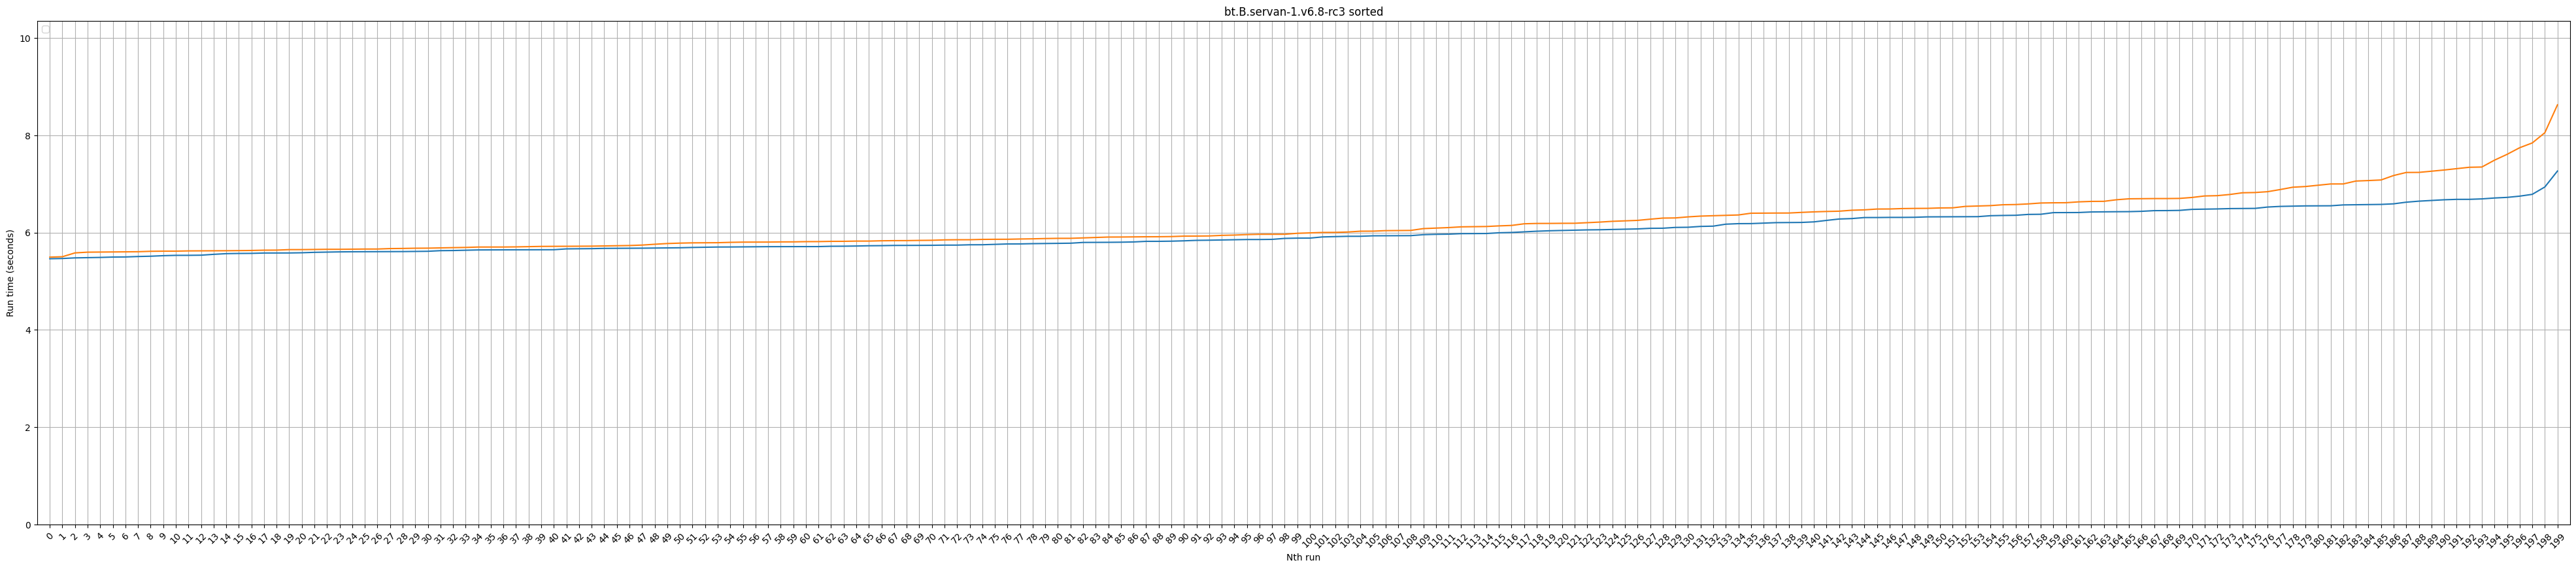

In [50]:
def get_hyperfine_runtimes(run_dir_path) -> List[float]:
    hyperfine_run_files = [file for file in os.listdir(run_dir_path) if file.endswith(".json")]
    if len(hyperfine_run_files) == 0 :
        return []
    if len(hyperfine_run_files) > 1 :
        print("WARNING : More than 1 hyperfine run files found in", run_dir_path)
    
    with open(os.path.join(run_dir_path, hyperfine_run_files[0])) as f:
        data = json.load(f)
    return data['results'][0]['times']


def plot_hyperfine_benchmark_dir(benchmark_dir_name, sort_values = True):
    dir_path = get_result_dir_path(benchmark_dir_name)
    nb_dir_path = os.path.join(dir_path, "nb")
    no_nb_dir_path = os.path.join(dir_path, "no_nb")

    times_nb = get_hyperfine_runtimes(nb_dir_path) if os.path.exists(nb_dir_path) else None
    times_no_nb = get_hyperfine_runtimes(no_nb_dir_path) if os.path.exists(no_nb_dir_path) else None
    
    if sort_values:
        times_nb.sort()
        times_no_nb.sort()
    init_runtimes_plot()
    if times_nb :
        plot_hyperfine_run(times_nb, benchmark_dir_name + " | NB enabled", nb_enabled_color, False)
    if times_no_nb :
        plot_hyperfine_run(times_no_nb, benchmark_dir_name + " | NB disabled", nb_disabled_color, False)
    plot_title = benchmark_dir_name + " sorted" if sort_values else " unsorted"
    plt.title(plot_title)
    plt.show()
    
    

plot_hyperfine_benchmark("bt.B.servan-1.v6.8-rc3")


# dir_path = get_result_dir_path("bt.B.servan-1.v6.8-rc3")
# nb_dir_path = os.path.join(dir_path, "nb")
# no_nb_dir_path = os.path.join(dir_path, "no_nb")

# times_nb = get_hyperfine_runtimes(nb_dir_path)
# times_no_nb = get_hyperfine_runtimes(no_nb_dir_path)

# plot_hyperfine_benchmark(times_nb, times_no_nb, benchmark_name="bt.B.servan-1.v6.8-rc3")




#### Hyperfine runs

bt.B.servan-1.v6.8-rc3


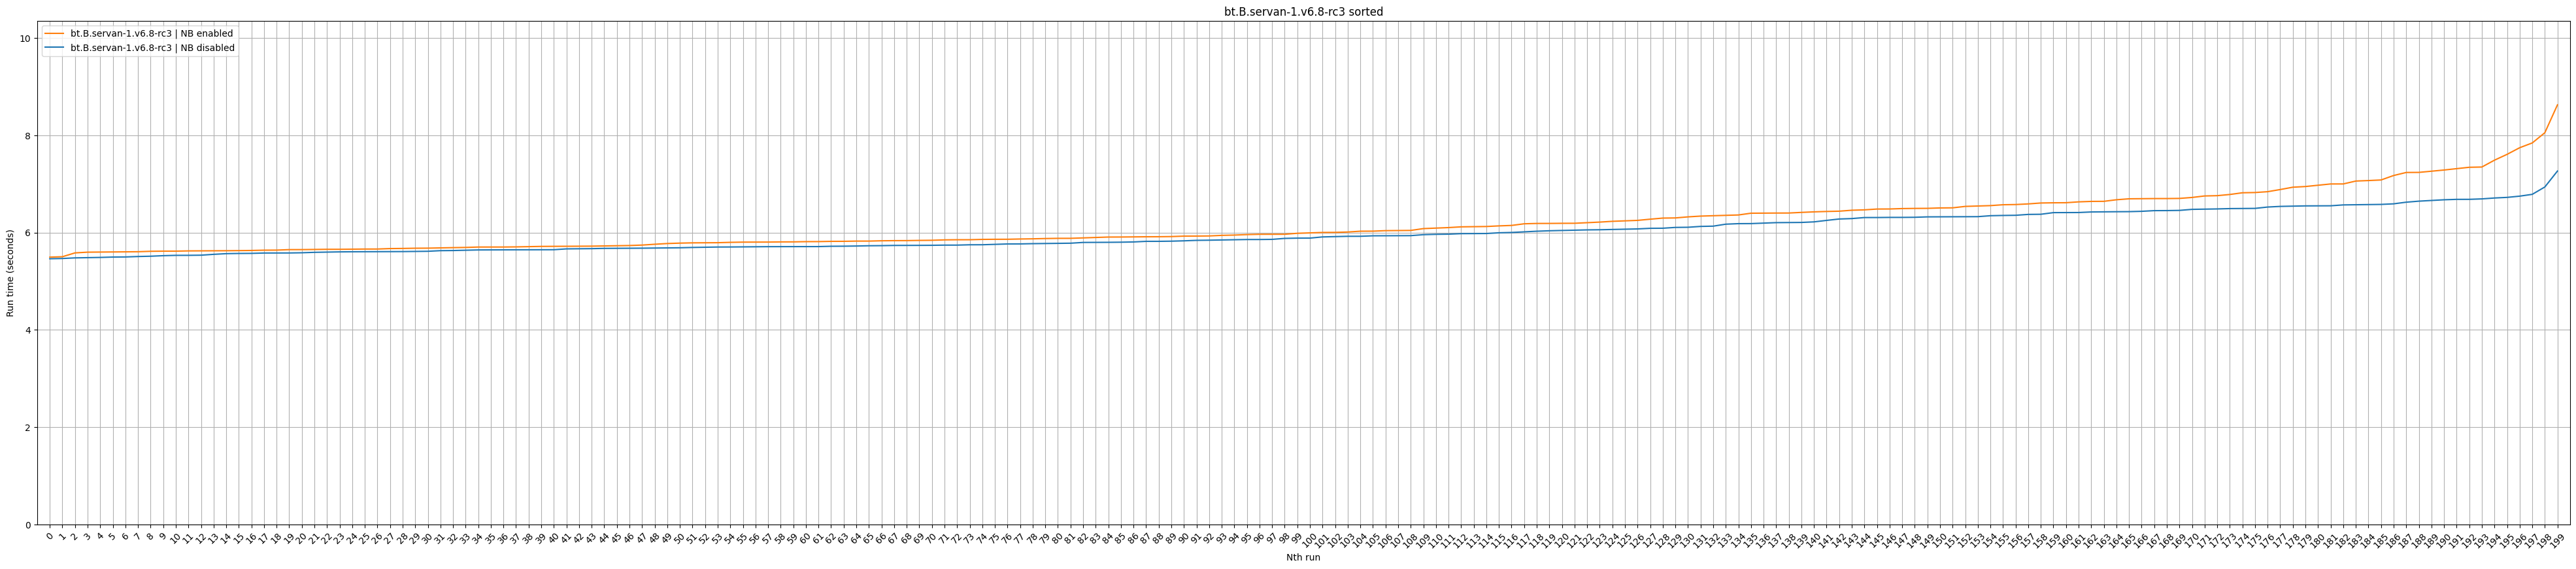

bt.C.servan-1.v6.8-rc3


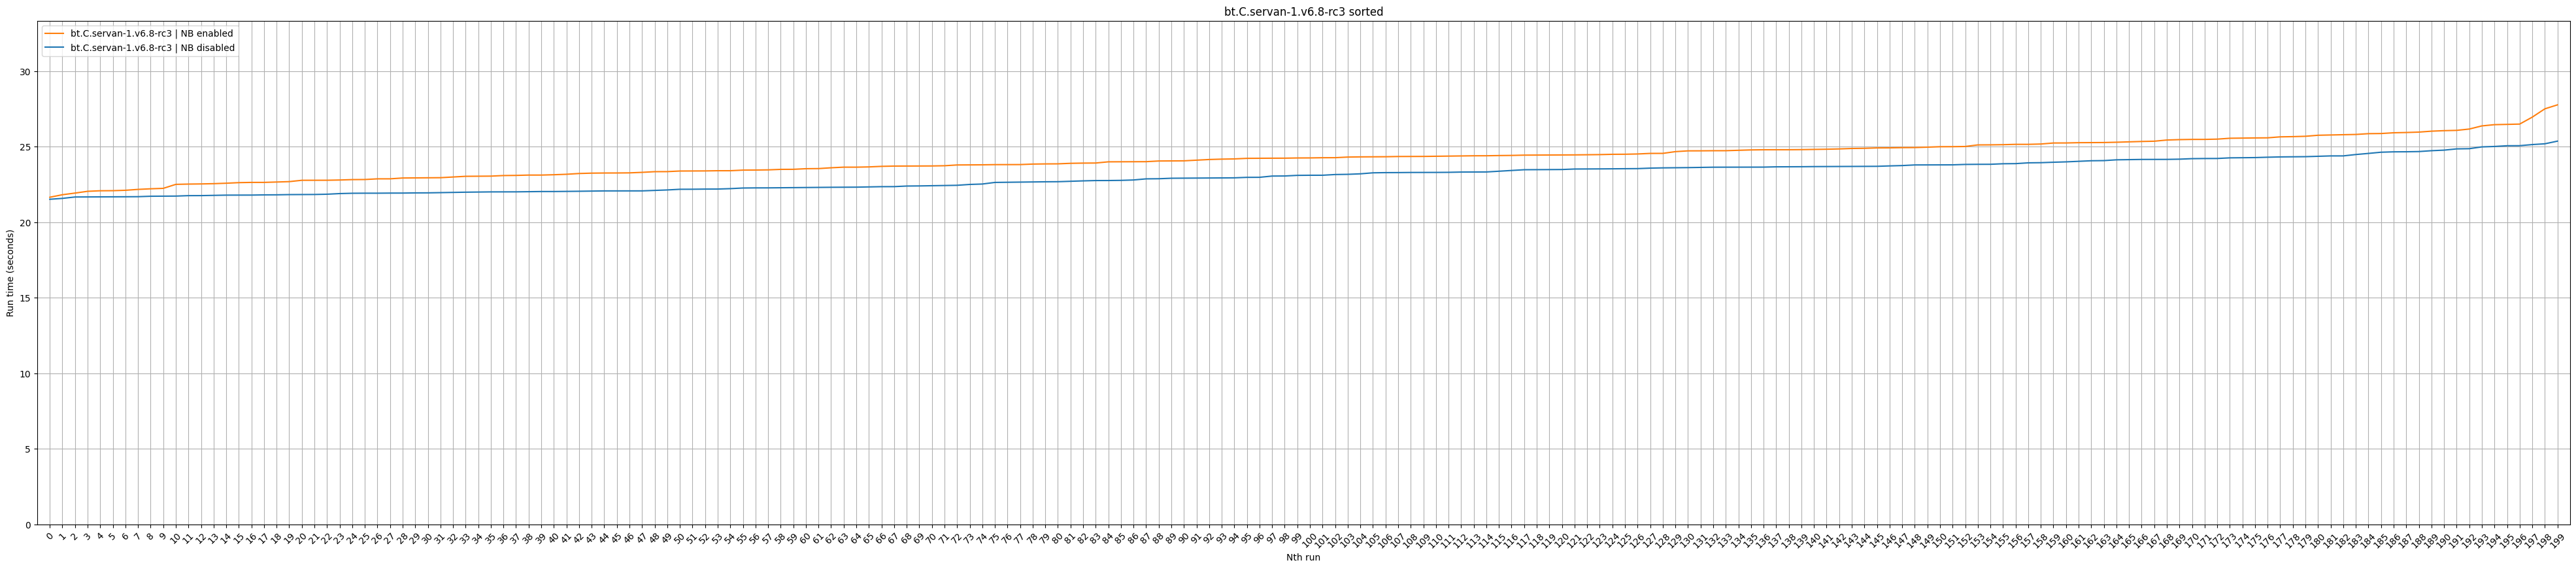

lu.B.servan-1.v6.8-rc3


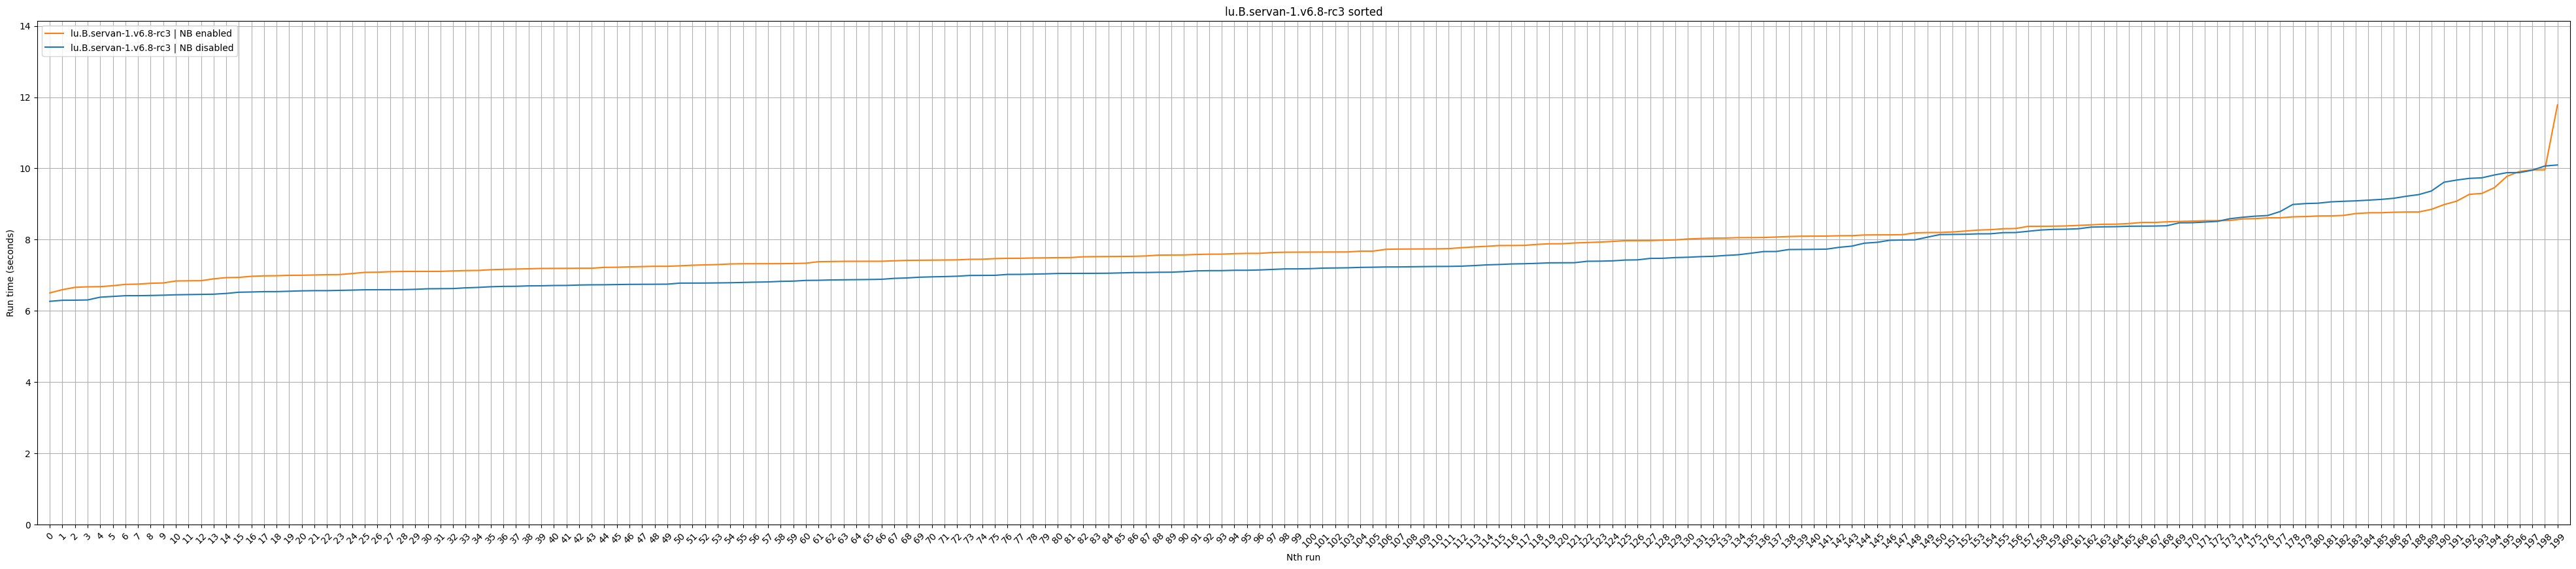

lu.C.servan-1.v6.8-rc3


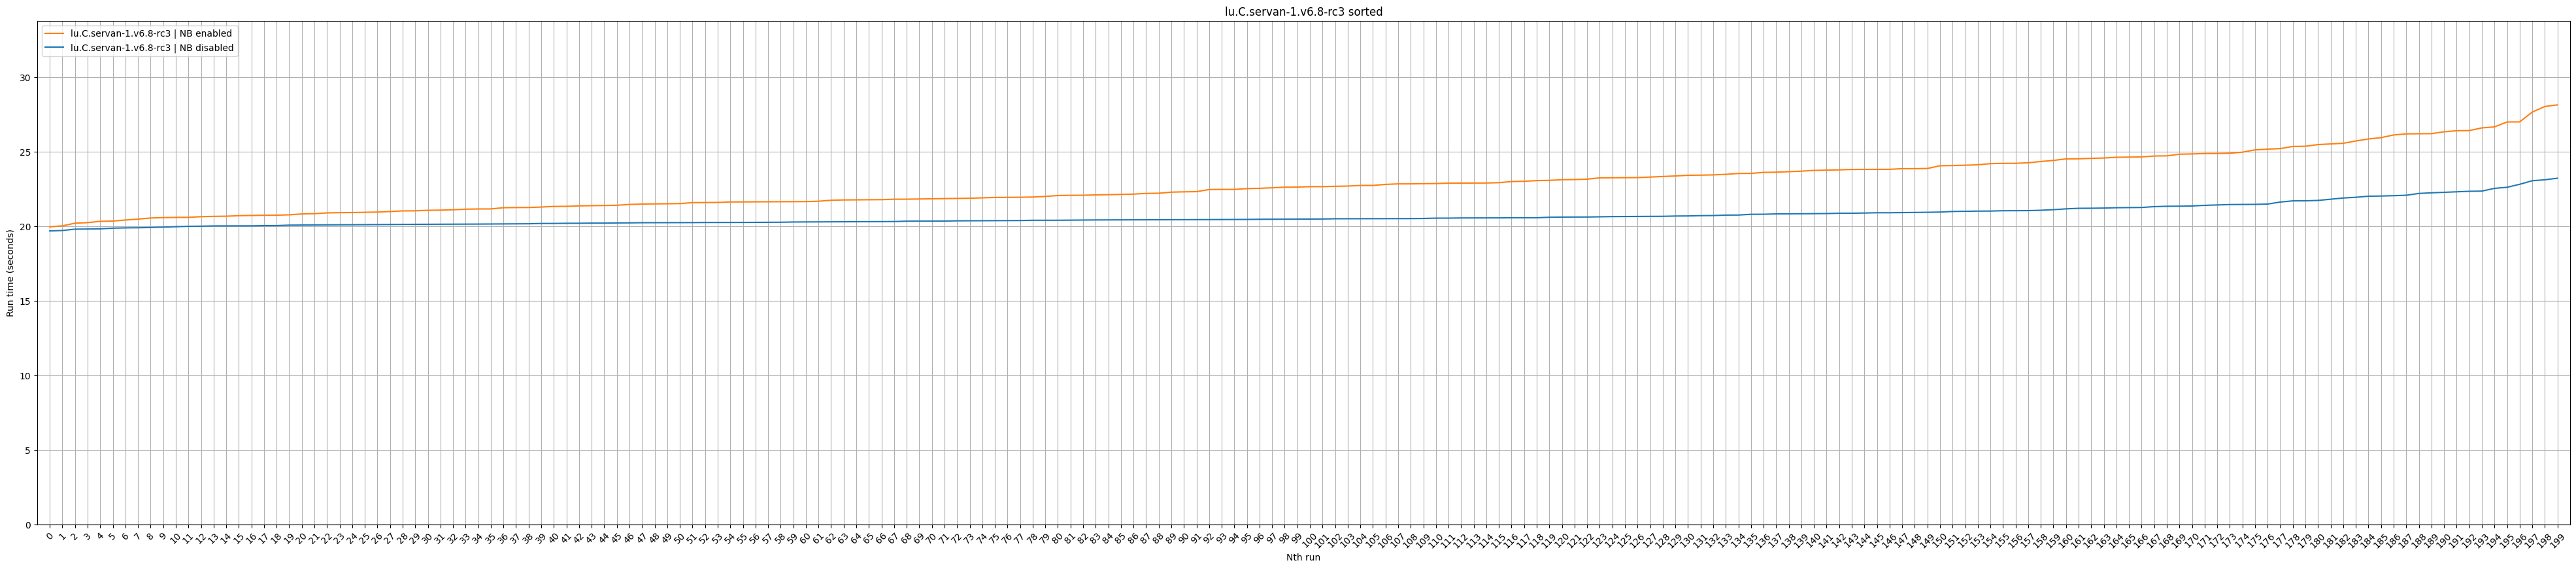

In [60]:
sort_values = True

for dir_name in benchmarks_dirs :
    dir_path = get_result_dir_path(dir_name)
    nb_dir_path = os.path.join(dir_path, "nb")
    no_nb_dir_path = os.path.join(dir_path, "no_nb")
    
    times_nb = get_hyperfine_runtimes(nb_dir_path) if os.path.exists(nb_dir_path) else []
    times_no_nb = get_hyperfine_runtimes(no_nb_dir_path) if os.path.exists(no_nb_dir_path) else []
        
    if not times_nb and not times_no_nb :
        continue
    
    print(dir_name)
    plot_hyperfine_benchmark(times_nb, times_no_nb, dir_name, sort_values=sort_values)
    

#### Trace-cmd runs

In [124]:
def count_trace_files(directory) :
    return len([file for file in os.listdir(directory) if file.endswith('.dat')])

for dir_name in benchmarks_dirs :
    dir_path = get_result_dir_path(dir_name)
    nb_dir_path = os.path.join(dir_path, "nb")
    no_nb_dir_path = os.path.join(dir_path, "no_nb")
    print(dir_path, " :")
    if os.path.exists(nb_dir_path) :
        print("    -", nb_dir_path, ":", count_trace_files(nb_dir_path), "trace runs")
    if os.path.exists(no_nb_dir_path) :
        print("    -", no_nb_dir_path, ":", count_trace_files(no_nb_dir_path), "trace runs")
    print("")

../results/bt.B.dahu-17.v6.8-rc3  :
    - ../results/bt.B.dahu-17.v6.8-rc3/nb : 200 trace runs
    - ../results/bt.B.dahu-17.v6.8-rc3/no_nb : 200 trace runs

../results/bt.B.servan-1.v6.8-rc3  :
    - ../results/bt.B.servan-1.v6.8-rc3/nb : 0 trace runs
    - ../results/bt.B.servan-1.v6.8-rc3/no_nb : 0 trace runs

../results/bt.C.dahu-28.v6.8-rc3  :
    - ../results/bt.C.dahu-28.v6.8-rc3/nb : 100 trace runs
    - ../results/bt.C.dahu-28.v6.8-rc3/no_nb : 100 trace runs

../results/bt.C.dahu.v6.1.0-17  :
    - ../results/bt.C.dahu.v6.1.0-17/nb : 50 trace runs

../results/bt.C.servan-1.v6.8-rc3  :
    - ../results/bt.C.servan-1.v6.8-rc3/nb : 0 trace runs
    - ../results/bt.C.servan-1.v6.8-rc3/no_nb : 0 trace runs

../results/bt.C.yeti.v6.1.0-17  :
    - ../results/bt.C.yeti.v6.1.0-17/nb : 50 trace runs
    - ../results/bt.C.yeti.v6.1.0-17/no_nb : 10 trace runs

../results/cache  :

../results/cg.C.servan-1.v6.8-rc3  :
    - ../results/cg.C.servan-1.v6.8-rc3/nb : 200 trace runs
    - ../re

#### General plotting

bt.B.dahu-17.v6.8-rc3


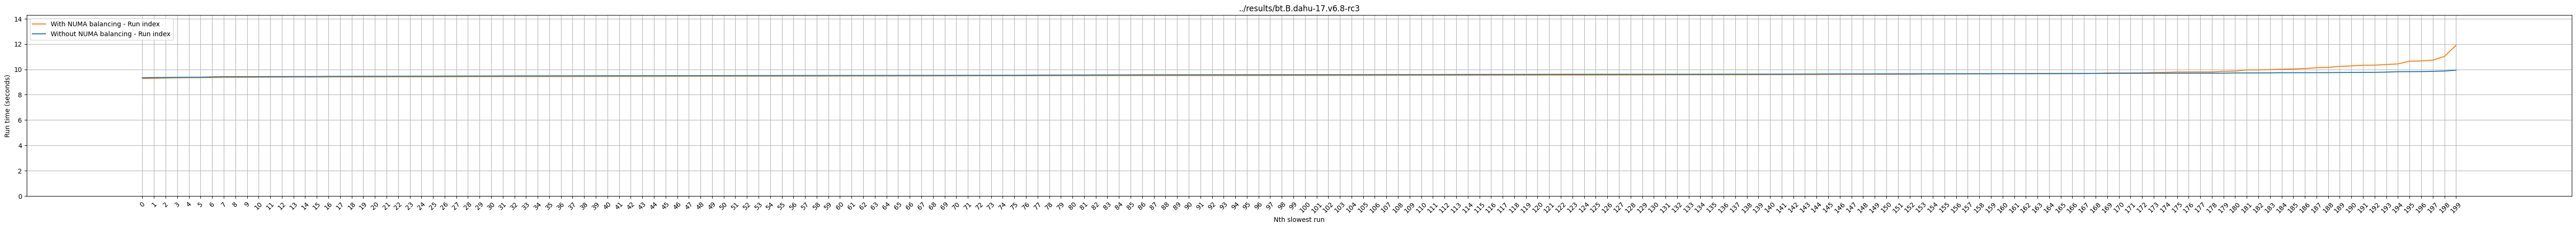

bt.C.dahu-28.v6.8-rc3


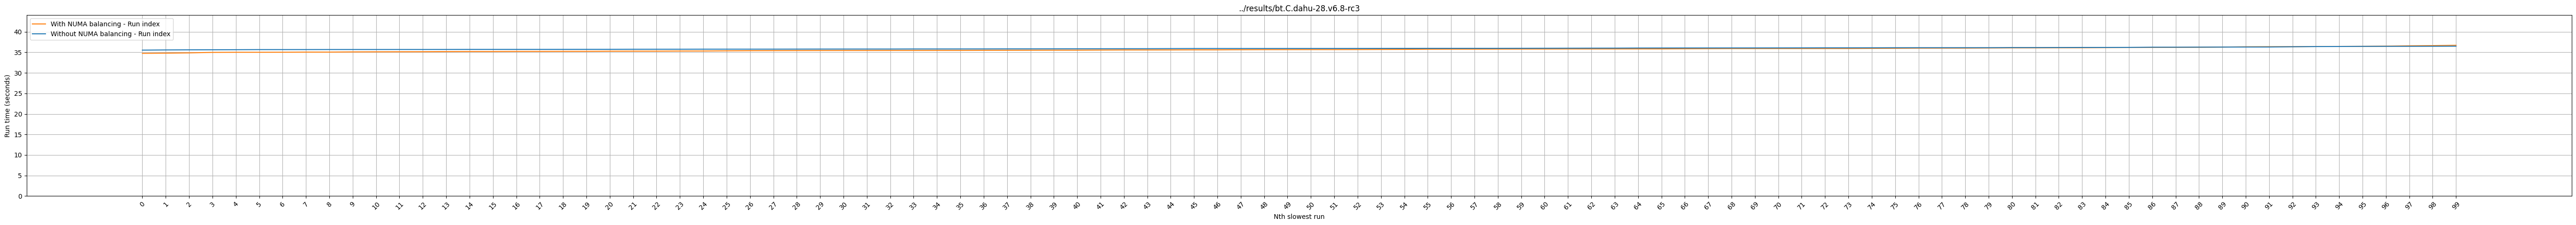

cg.C.servan-1.v6.8-rc3


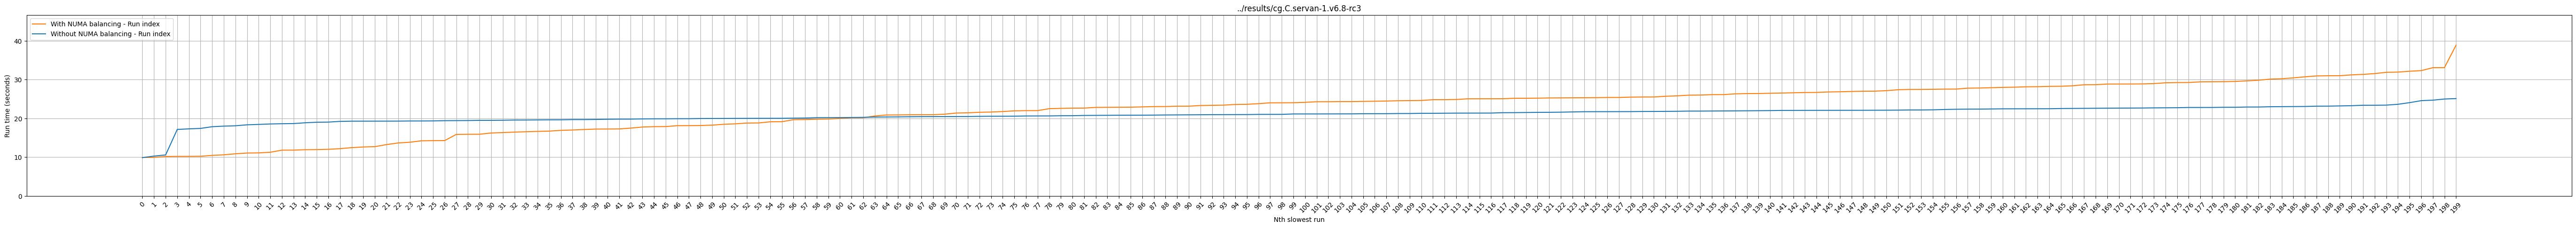

ft.C.yeti-4.v6.8-rc3


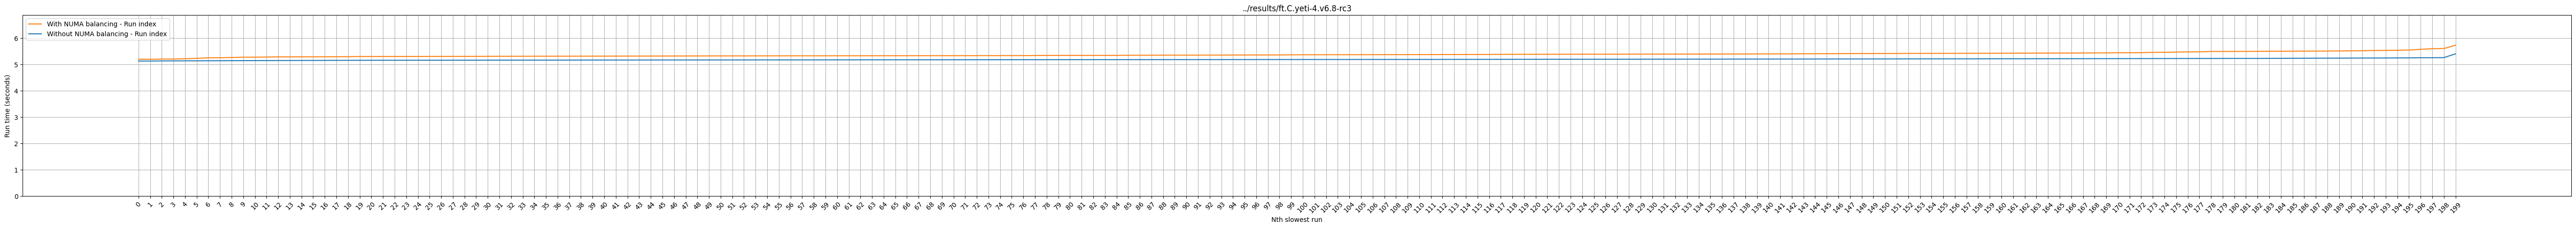

lu.B.dahu-17.v6.8-rc3


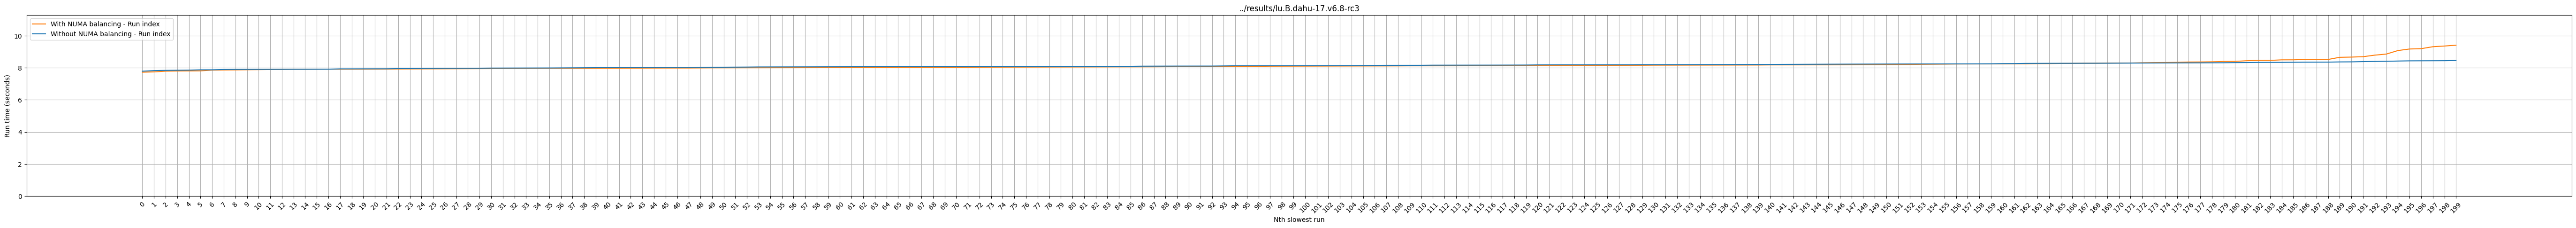

lu.C.dahu-18.v6.8-rc3


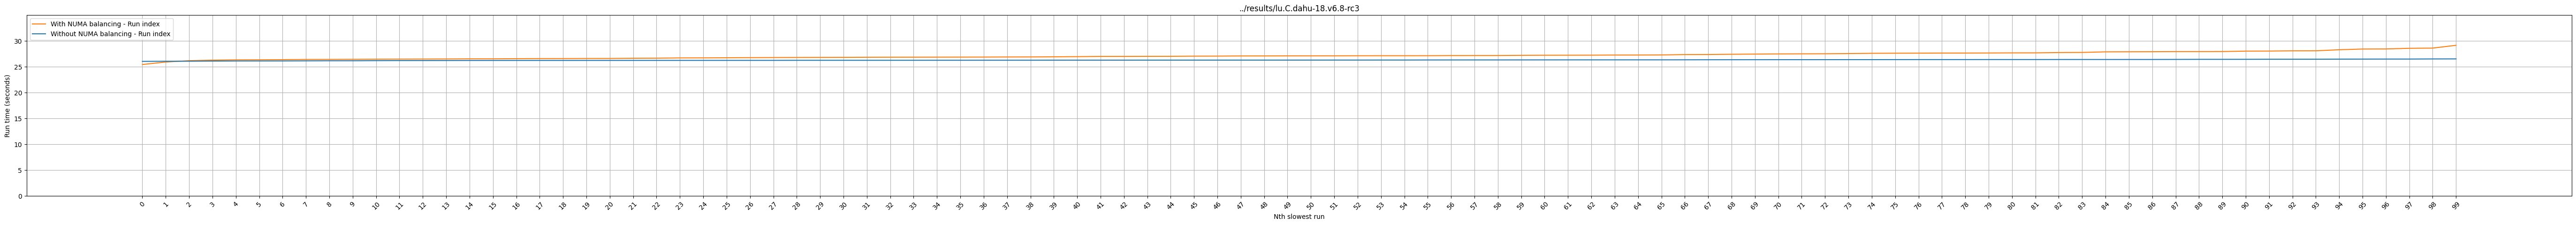

Done


In [107]:
for dir in individual_results_dirs :
    if not dir.endswith('rc3'):
        continue
    test_dir = os.path.join(results_dir, dir)
    print(dir)
    show_results_for(test_dir, show_run_index=False, fig_width=70)
print("Done")

bt.C.dahu.v6.1.0-17


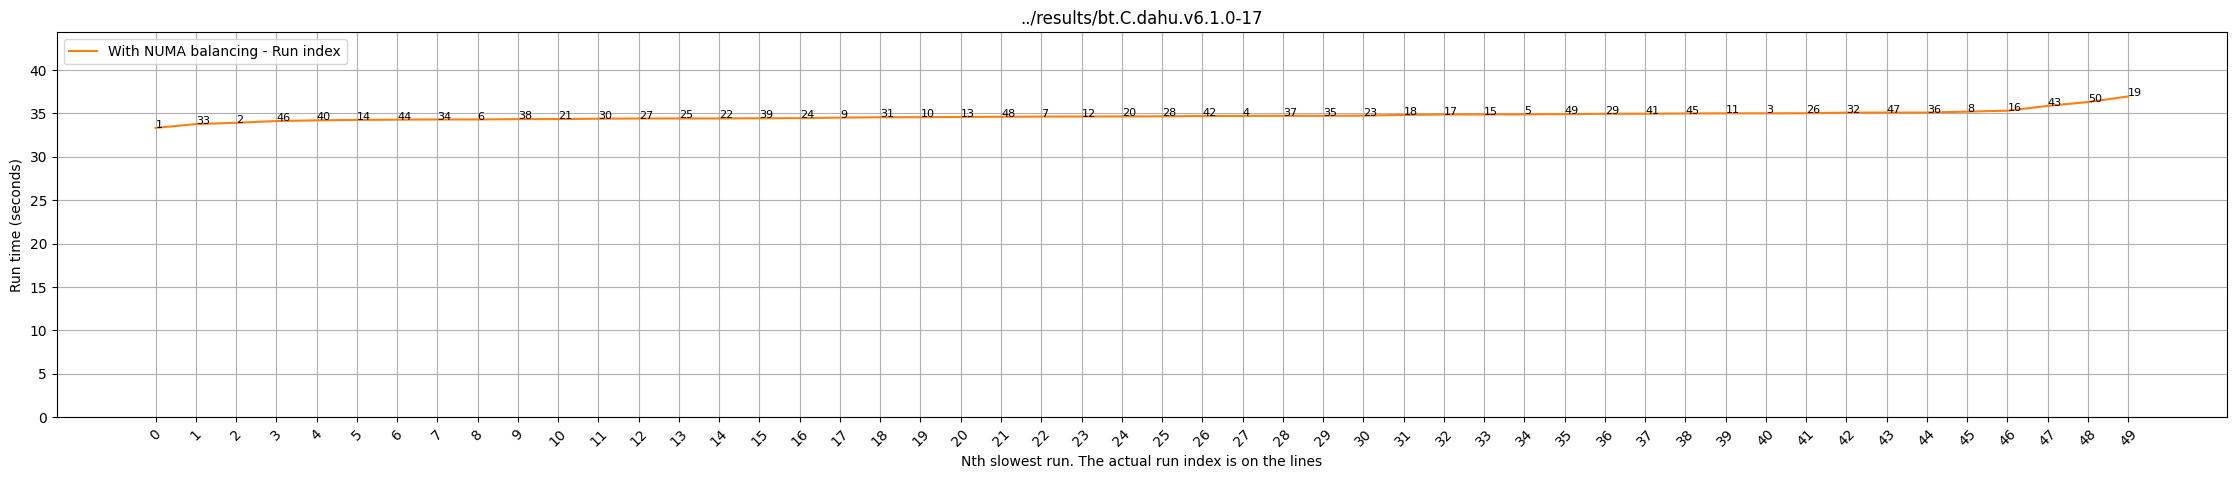

bt.C.yeti.v6.1.0-17


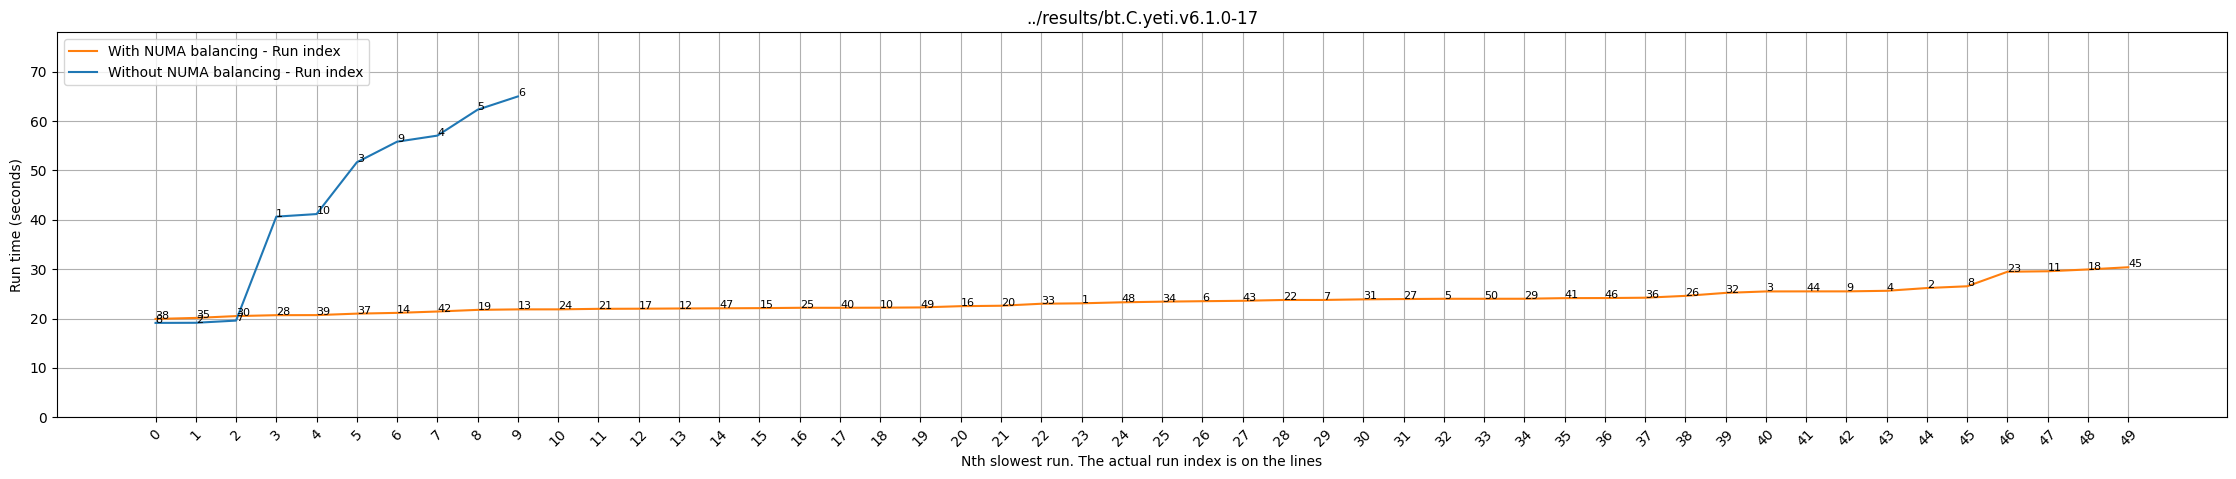

cg.C.servan-2.v6.1.0-17


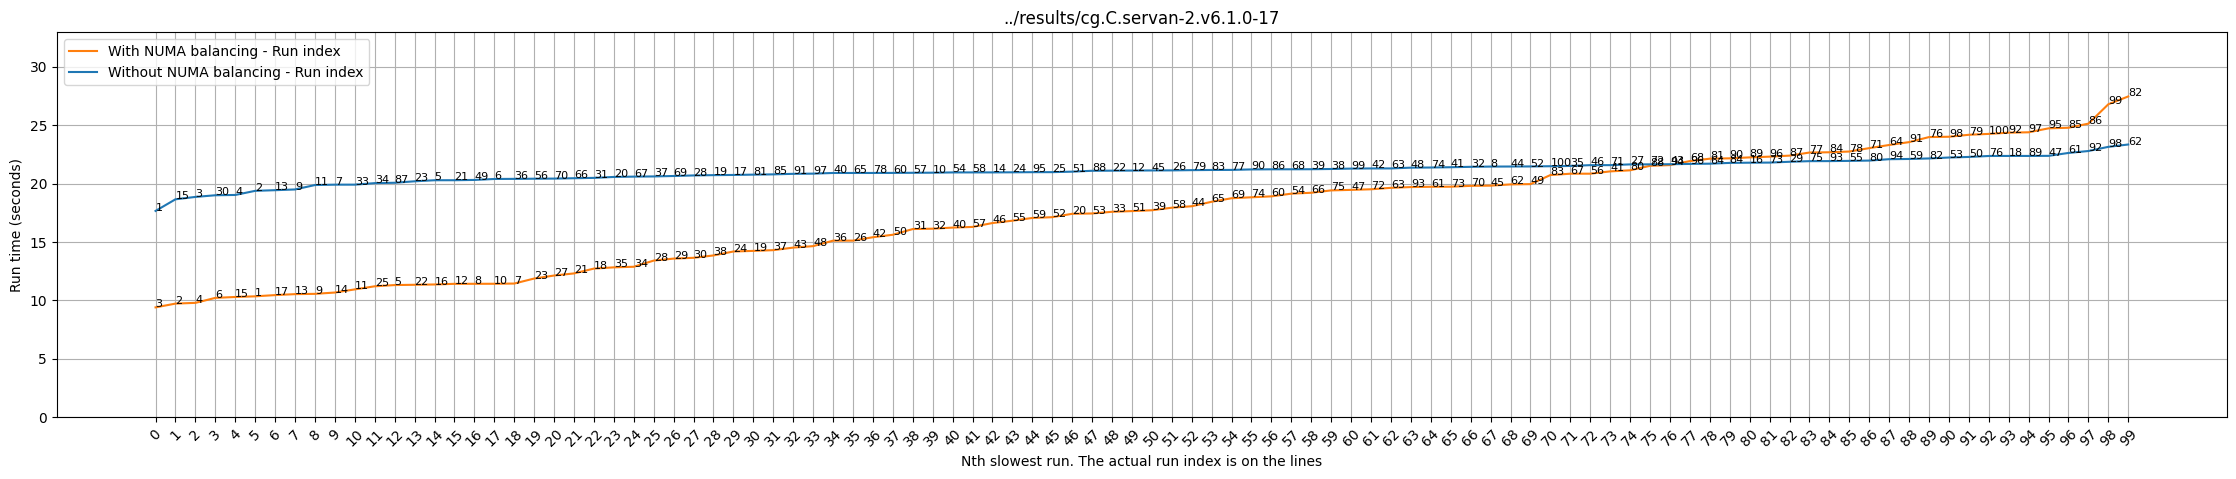

cg.C.servan.v6.1.0-17


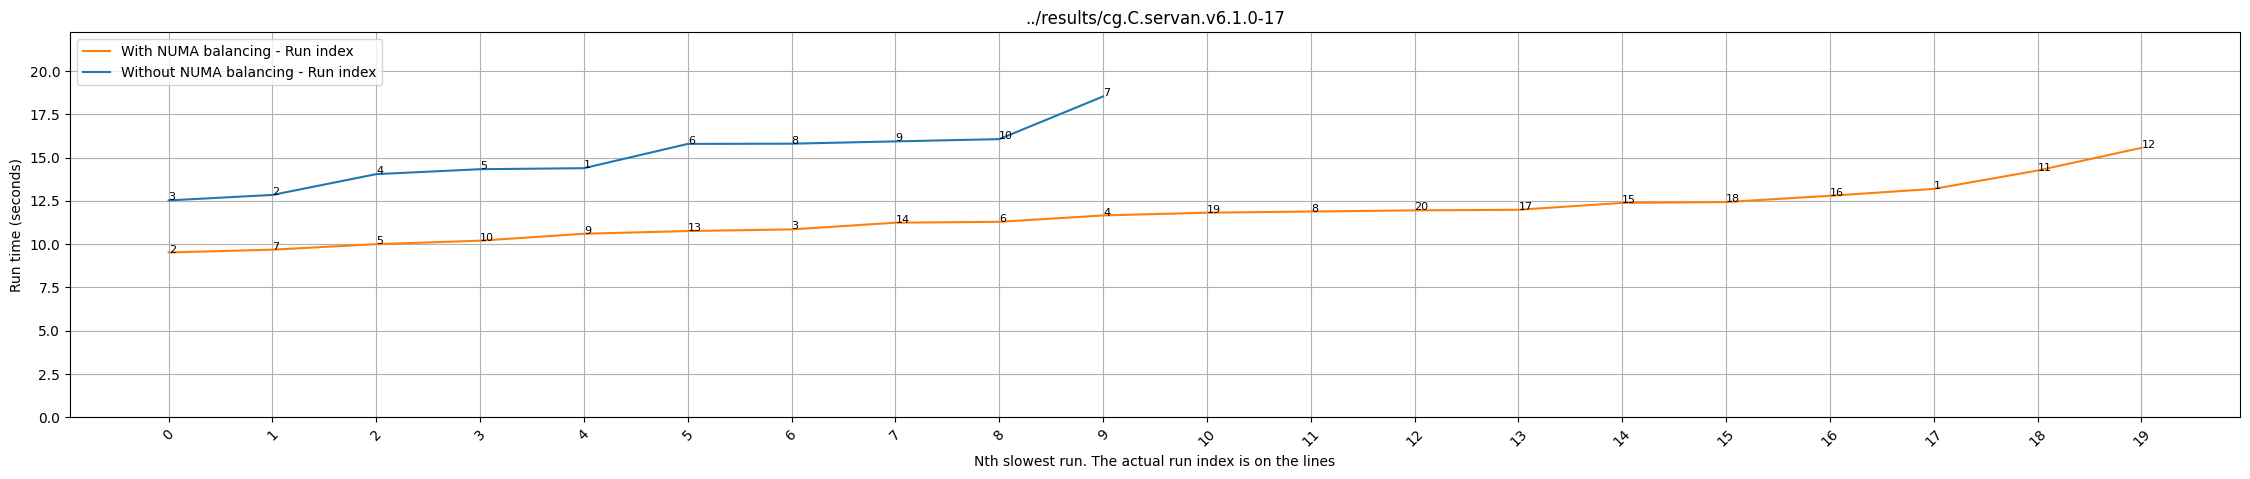

ep.D.dahu.v6.1.0-17


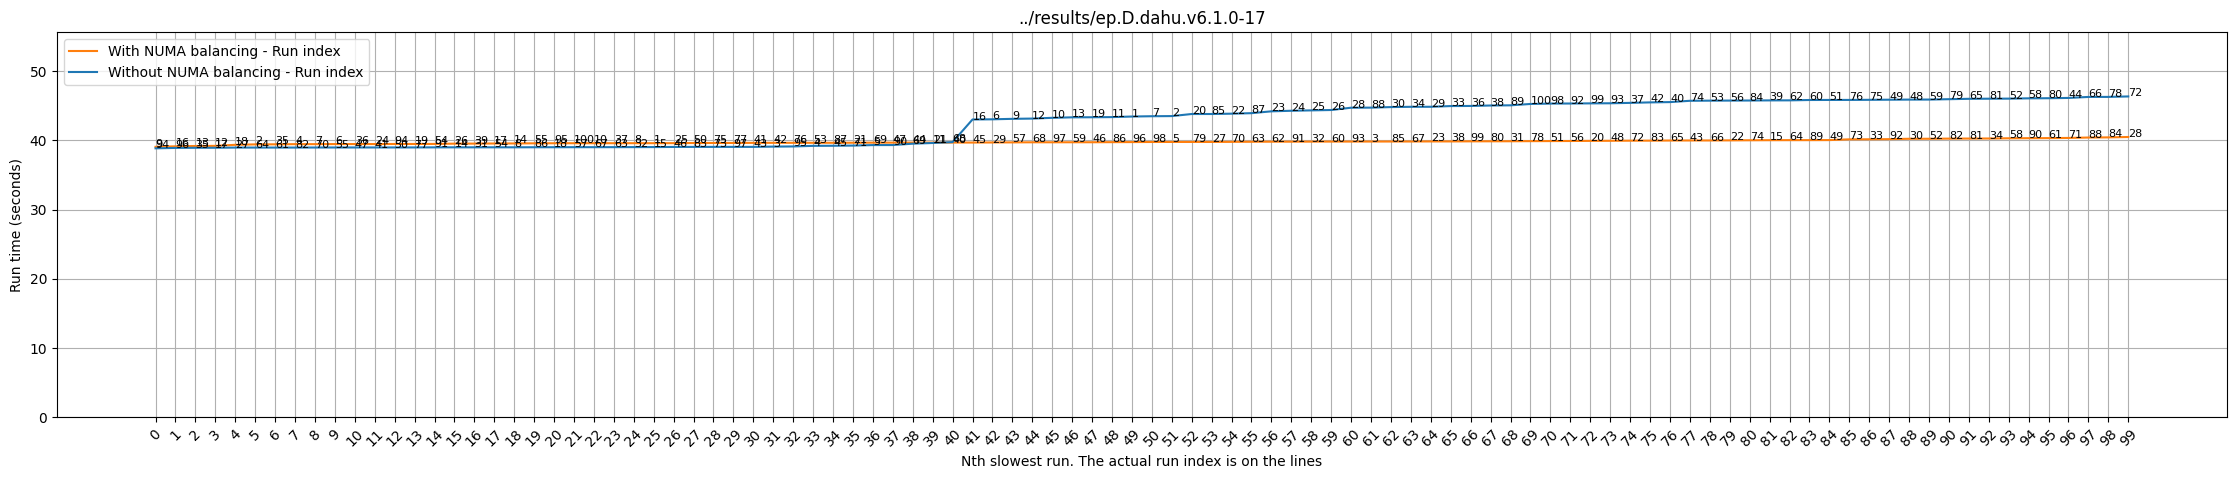

ft.C.dahu.v6.1.0-17


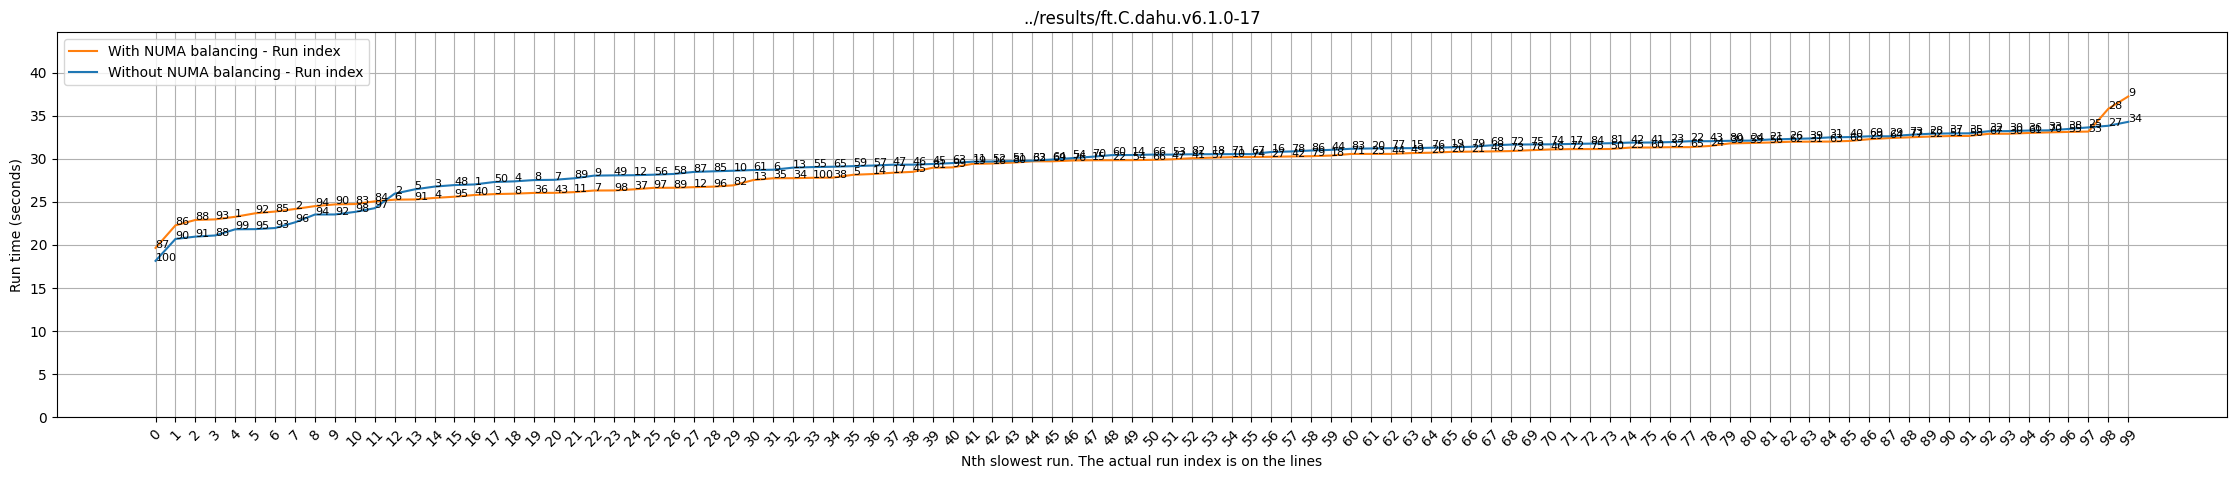

ft.C.yeti-1.v6.1.0-17


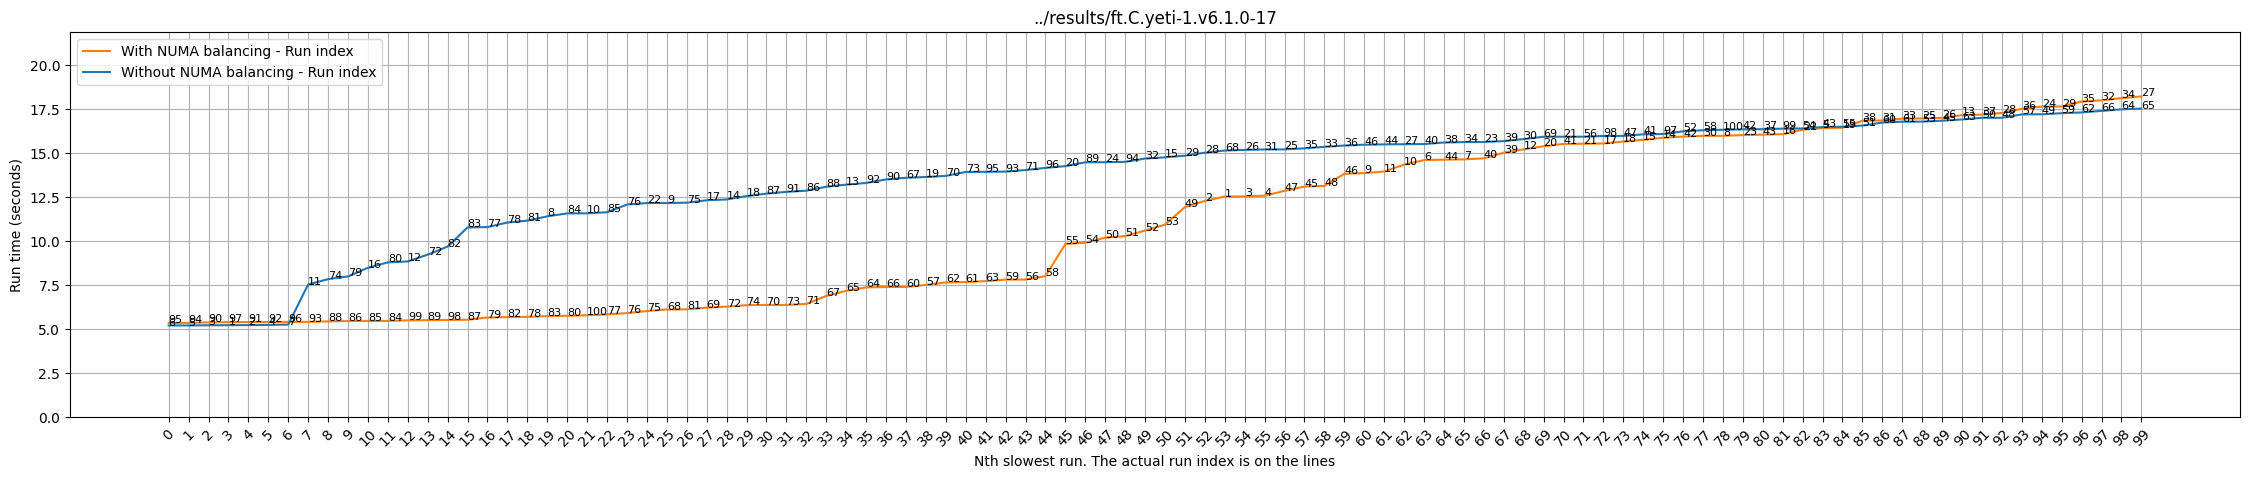

ft.D.yeti.v6.1.0-17


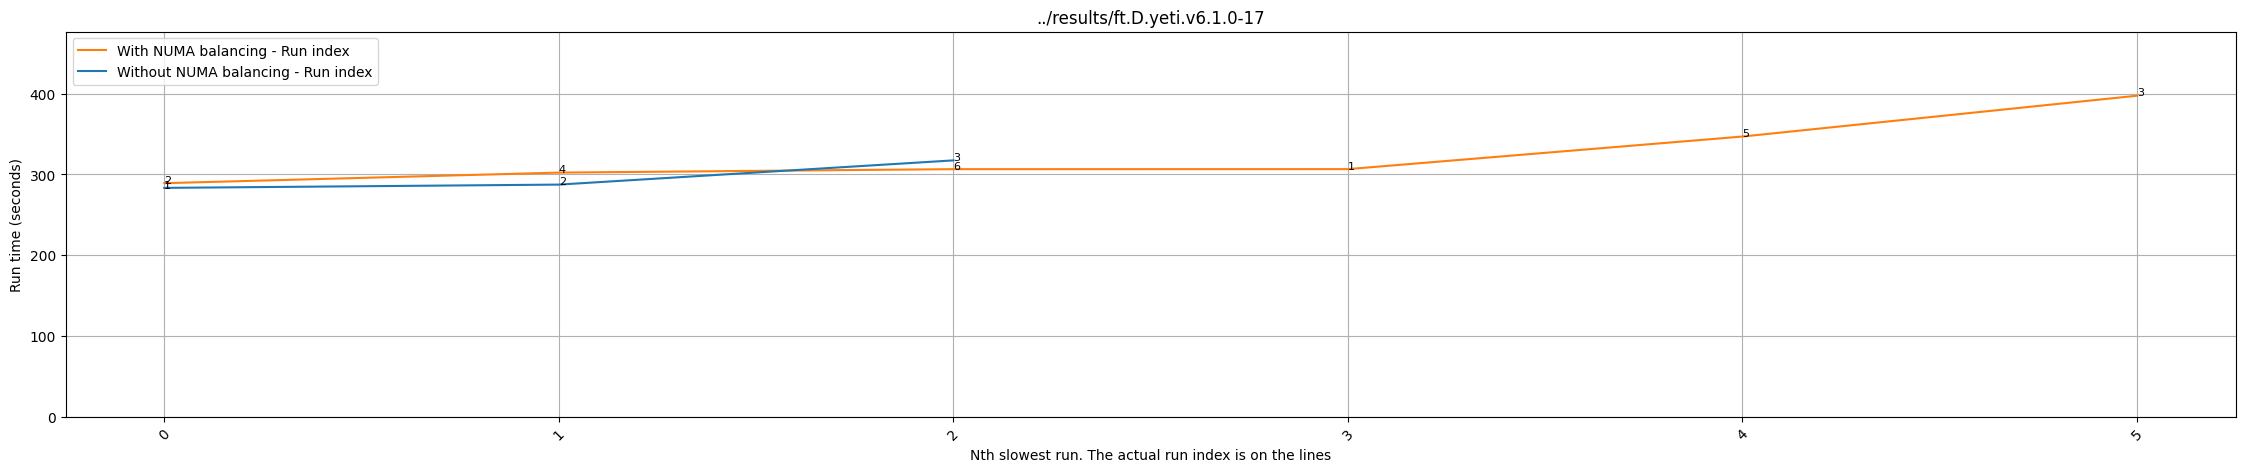

lu.C.dahu-30.v6.1.0-17


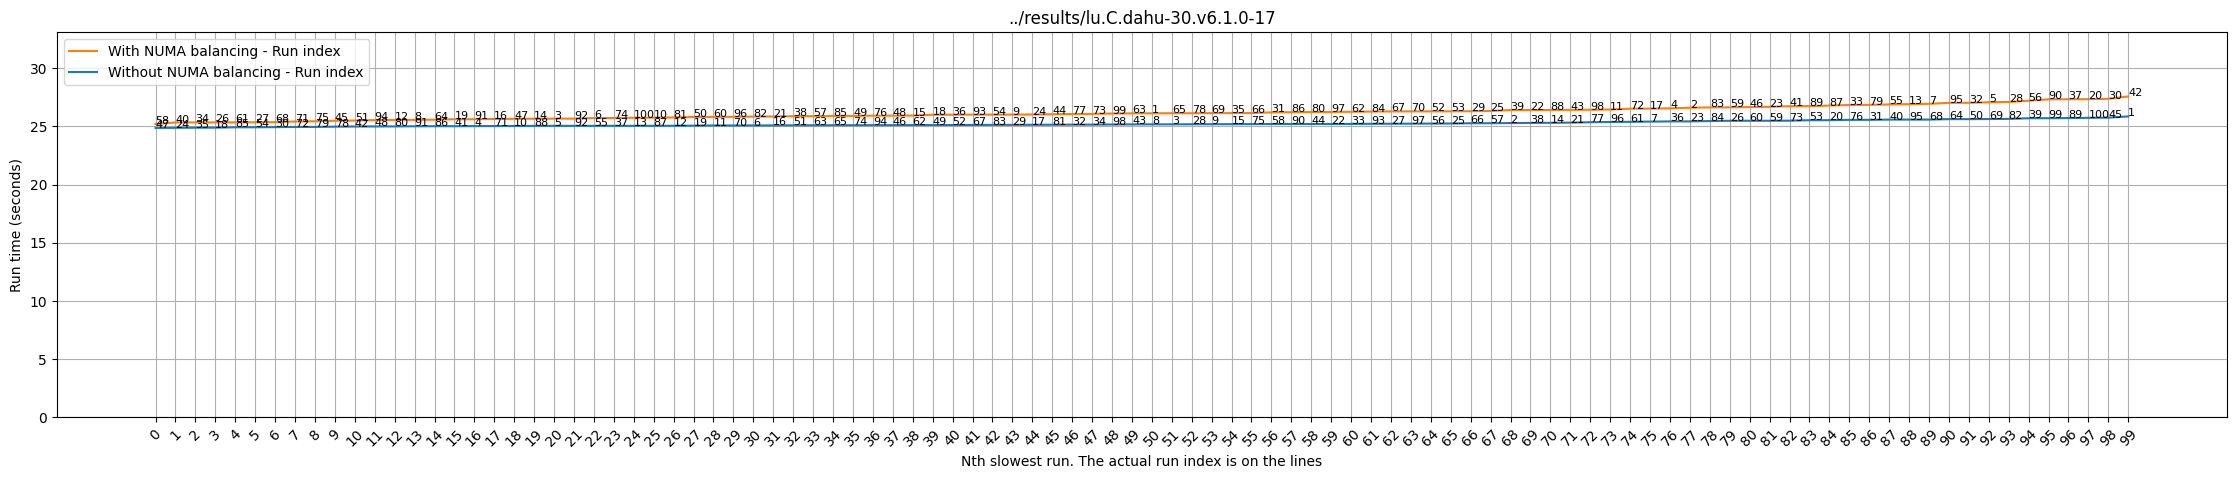

lu.C.dahu.v6.1.0-17


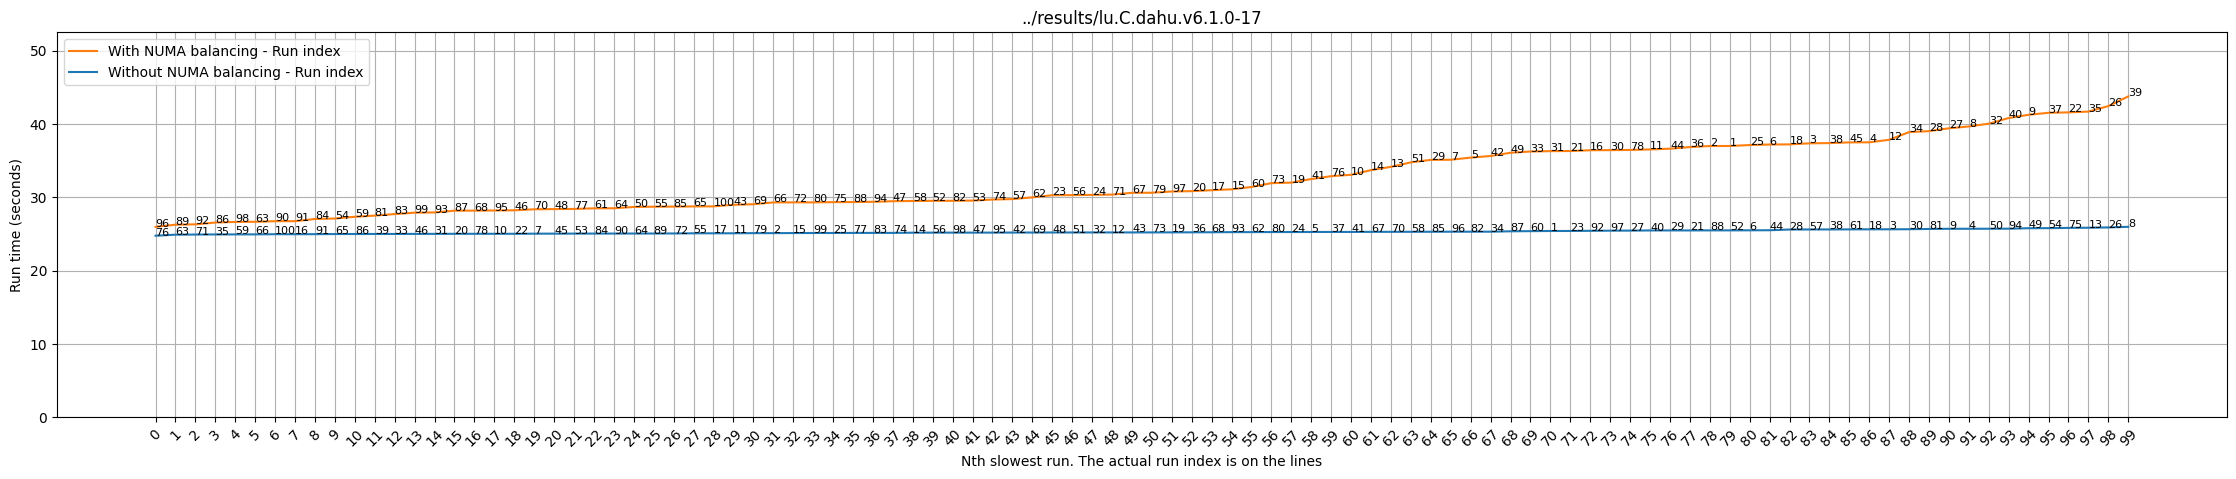

lu.D.yeti.v6.1.0-17


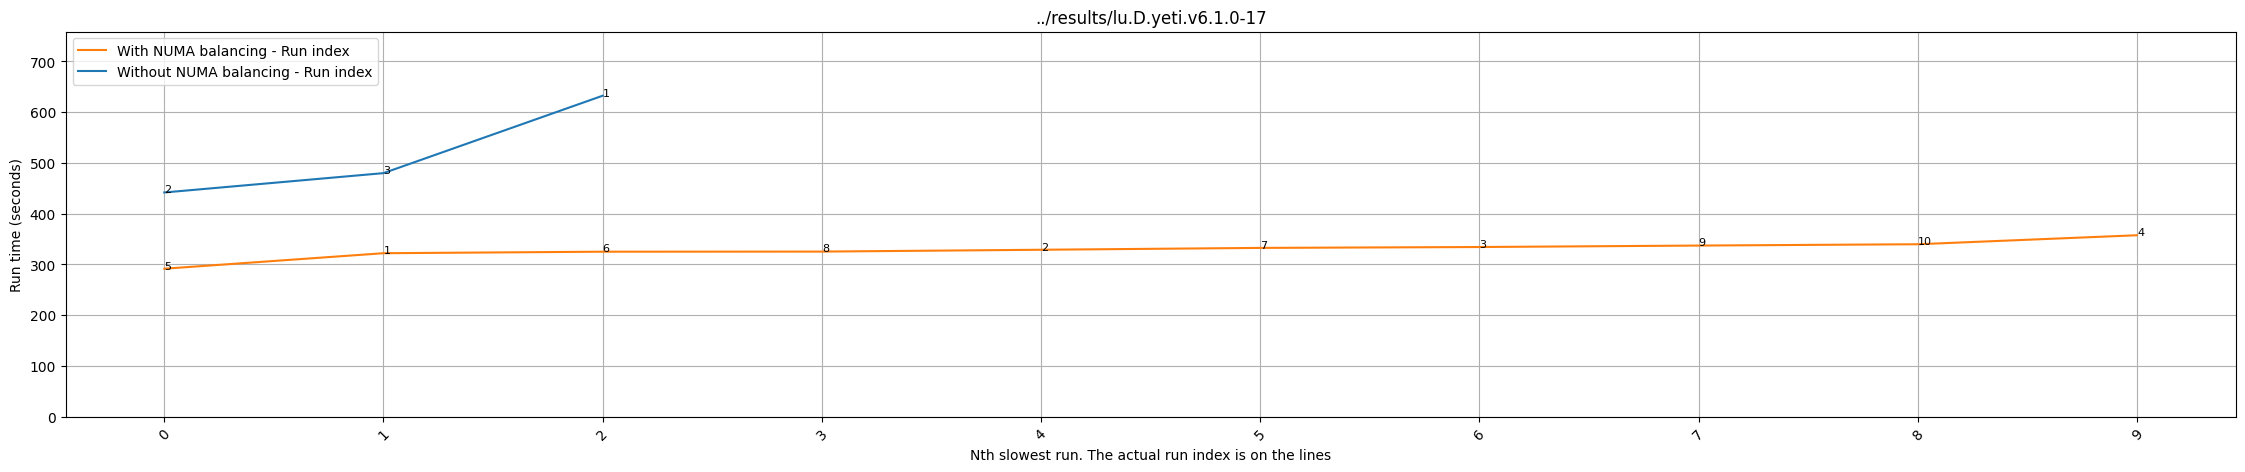

mg.d.dahu-28.v6.1.0-17


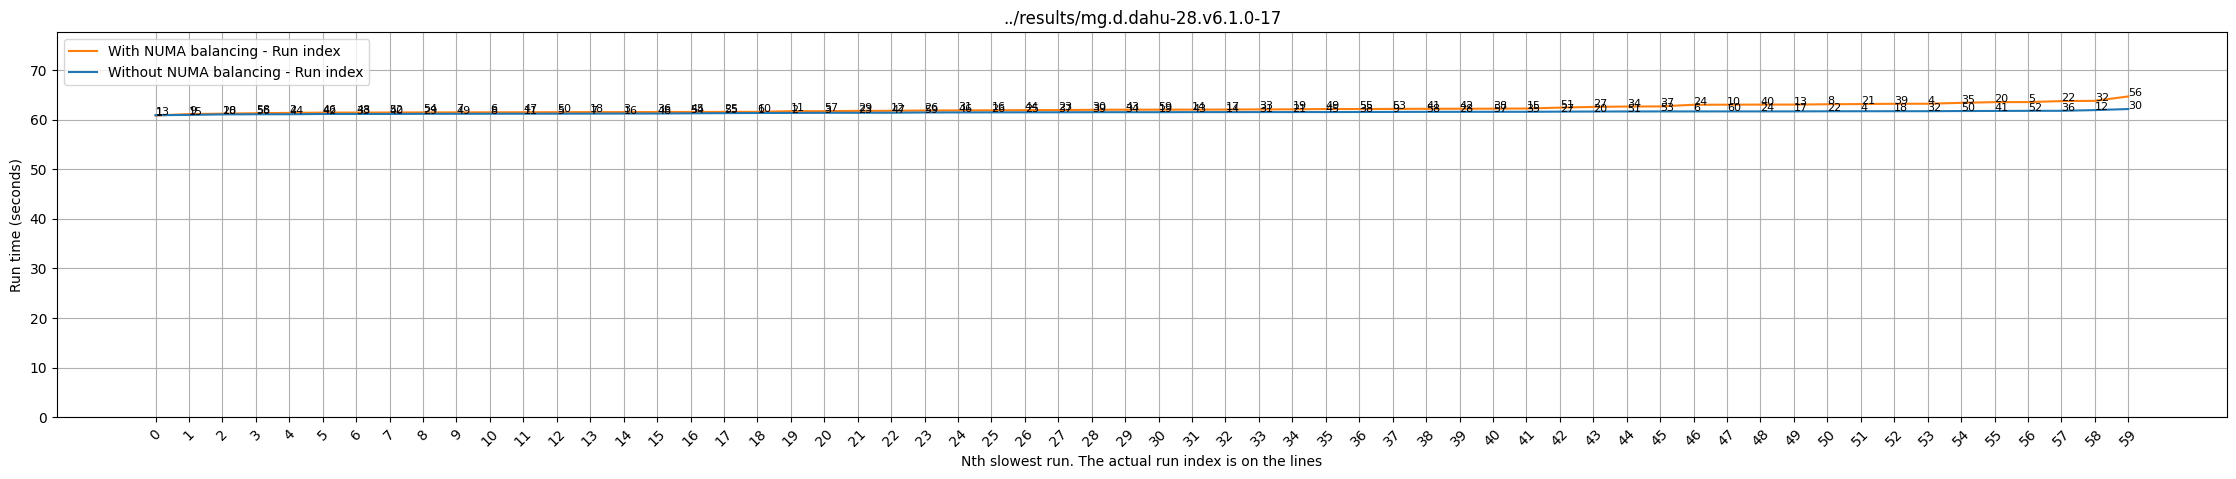

rsync-command
plot_trace_cmd_runtimes : ERROR - both with and without NUMA balancing data frames are None
sp.C.dahu.v6.1.0-17


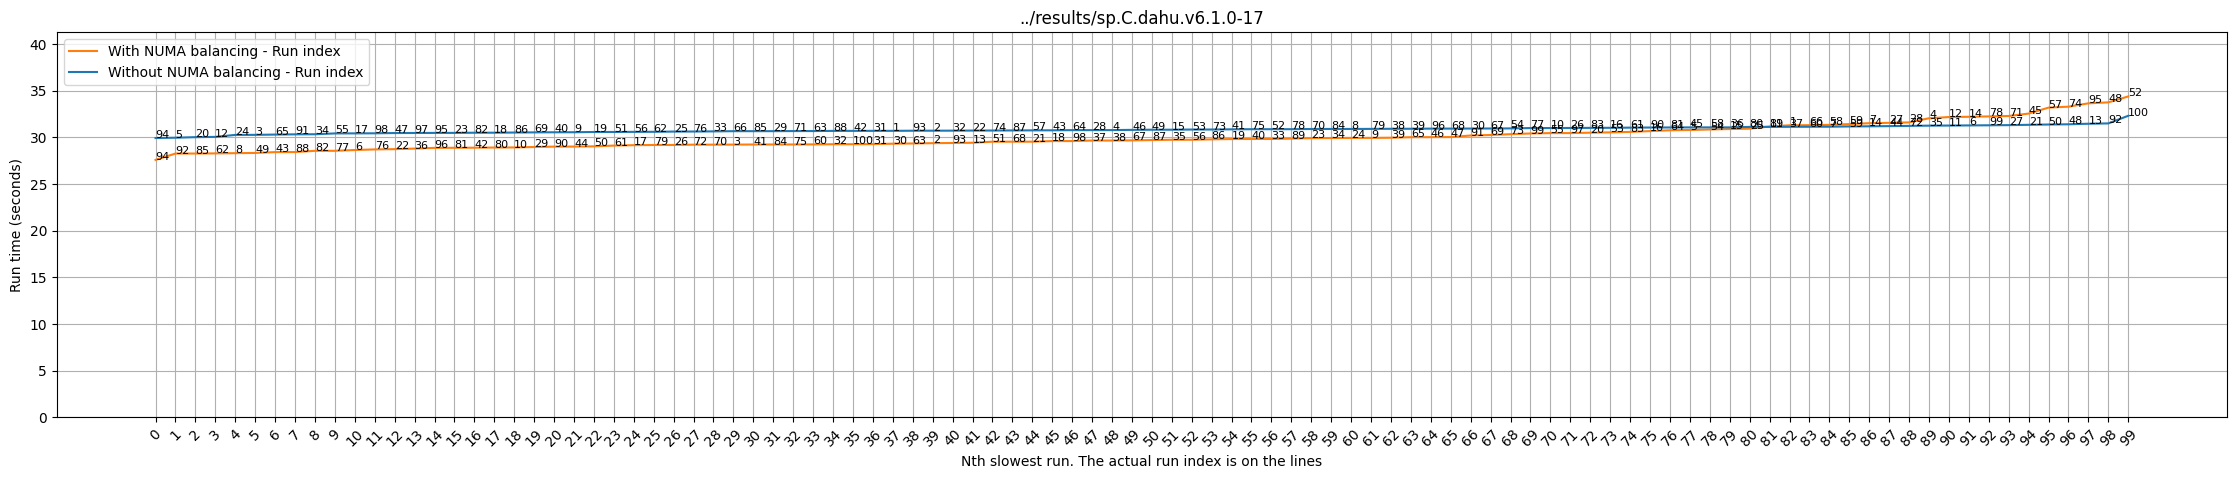

ua.C.dahu-30.v6.1.0-17


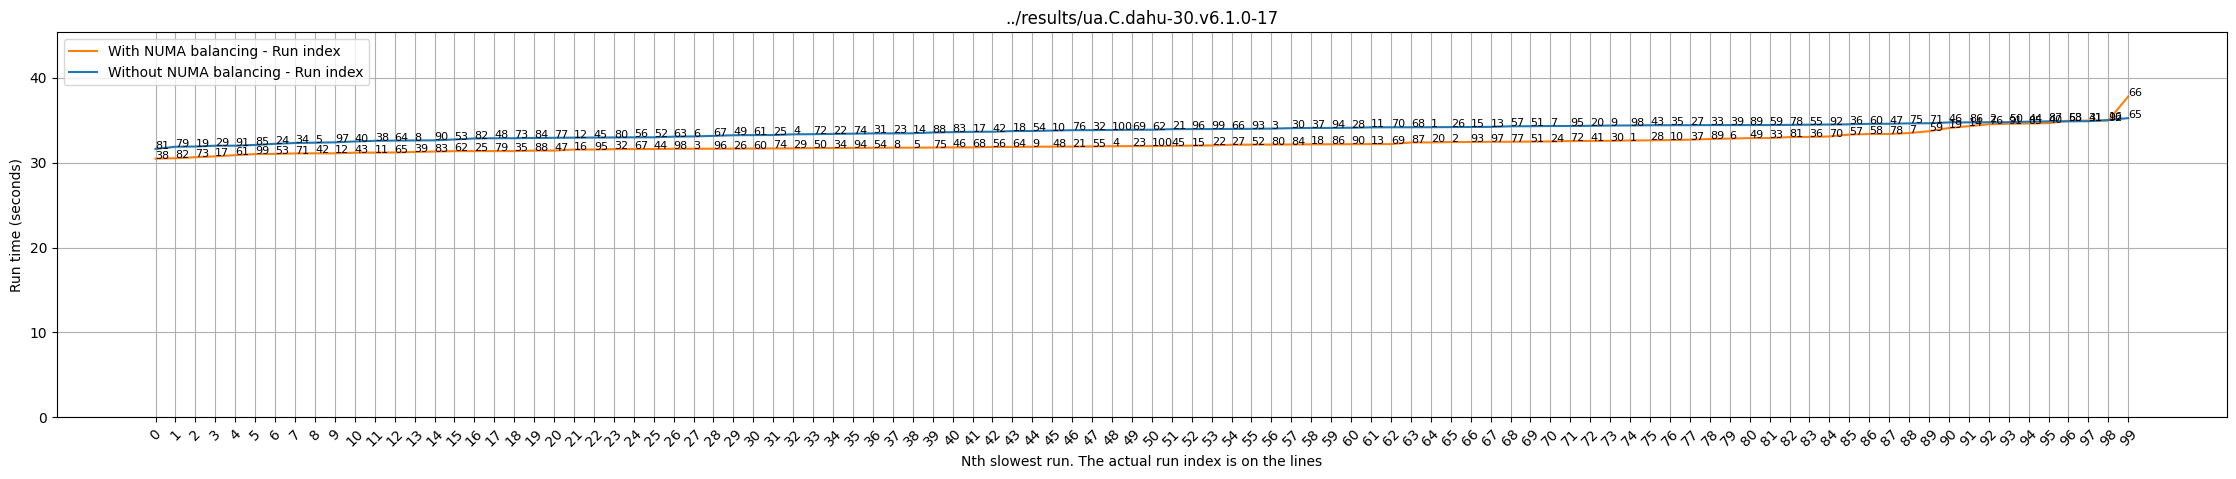

Done


In [108]:
for dir in individual_results_dirs :
    if dir.endswith('rc3'):
        continue
    print(dir)
    test_dir = os.path.join(results_dir, dir)
    show_results_for(test_dir, show_run_index=True)
print("Done")

#### Specifics

In [126]:
for idx, dir in enumerate(individual_results_dirs) :
    dir_path = os.path.join(results_dir, dir)
    print(f"{idx} : {dir}")

def print_result_idx(idx) :
    show_results_for(os.path.join(results_dir, individual_results_dirs[idx]), show_run_index=True, fig_width=70)

0 : bt.B.dahu-17.v6.8-rc3
1 : bt.B.servan-1.v6.8-rc3
2 : bt.C.dahu-28.v6.8-rc3
3 : bt.C.dahu.v6.1.0-17
4 : bt.C.servan-1.v6.8-rc3
5 : bt.C.yeti.v6.1.0-17
6 : cache
7 : cg.C.servan-1.v6.8-rc3
8 : cg.C.servan-2.v6.1.0-17
9 : cg.C.servan.v6.1.0-17
10 : ep.D.dahu.v6.1.0-17
11 : ft.C.dahu.v6.1.0-17
12 : ft.C.yeti-1.v6.1.0-17
13 : ft.C.yeti-4.v6.8-rc3
14 : ft.D.yeti.v6.1.0-17
15 : lu.B.dahu-17.v6.8-rc3
16 : lu.C.dahu-18.v6.8-rc3
17 : lu.C.dahu-30.v6.1.0-17
18 : lu.C.dahu.v6.1.0-17
19 : lu.D.yeti.v6.1.0-17
20 : mg.d.dahu-28.v6.1.0-17
21 : rsync-command
22 : sp.C.dahu.v6.1.0-17
23 : ua.C.dahu-30.v6.1.0-17


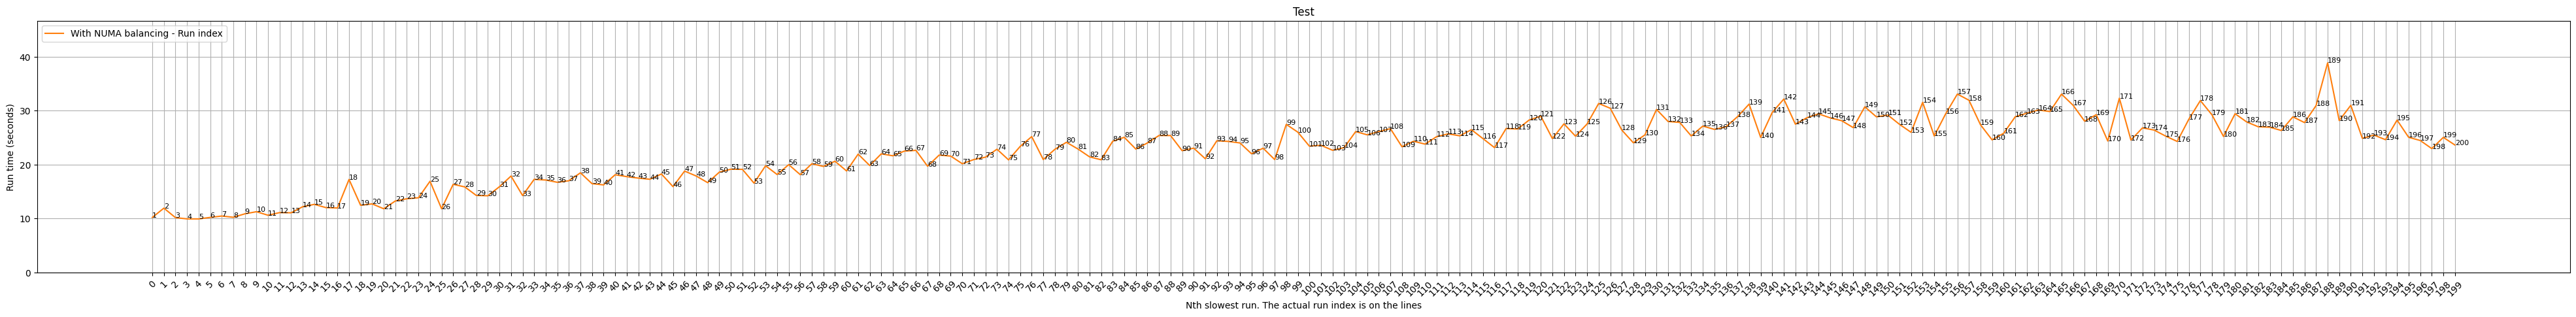

In [123]:
#TODO Have a function that does the os path join from results_dir
df = get_runtimes_dataframe(os.path.join(results_dir, "cg.C.servan-1.v6.8-rc3/nb"))
df['run_index'] = df['filename'].map(get_run_index)
df.sort_values('run_index', ignore_index=True, inplace=True)
df

plot_trace_cmd_runtimes(df, None, "Test", show_run_index = True, fig_width = 50)

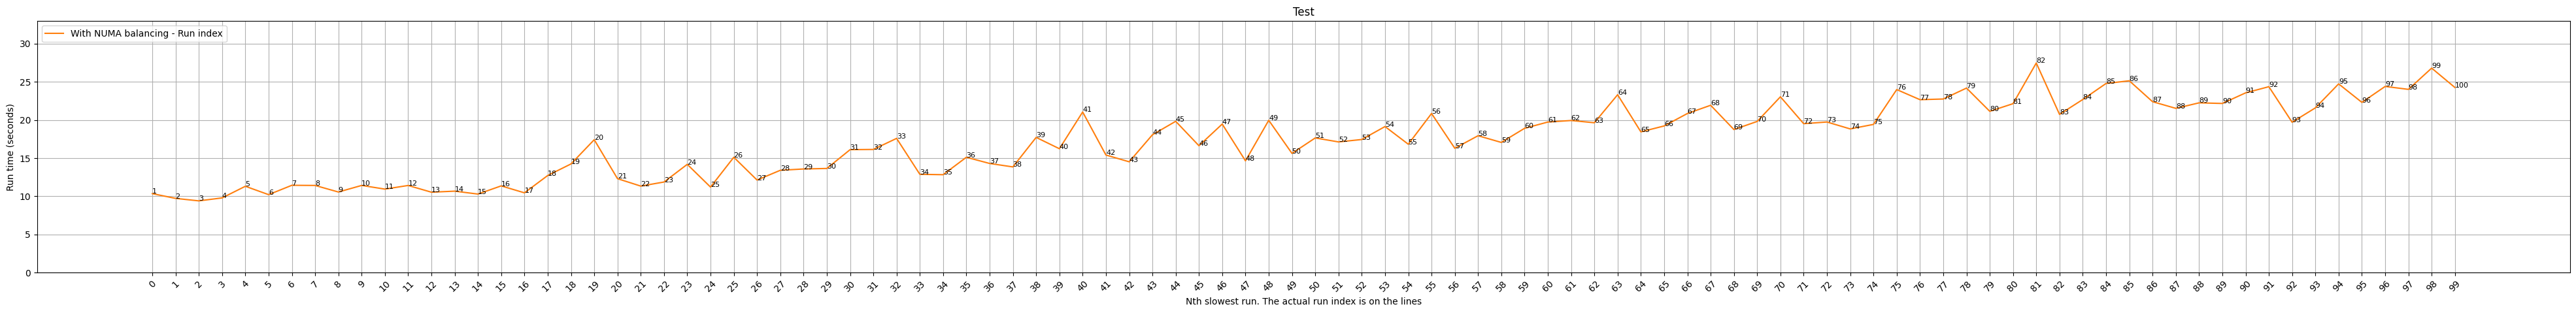

In [132]:
df = get_runtimes_dataframe(os.path.join(results_dir, "cg.C.servan-2.v6.1.0-17/nb"))
df['run_index'] = df['filename'].map(get_run_index)
df.sort_values('run_index', ignore_index=True, inplace=True)
df

plot_trace_cmd_runtimes(df, None, "Test", show_run_index = True, fig_width = 50)

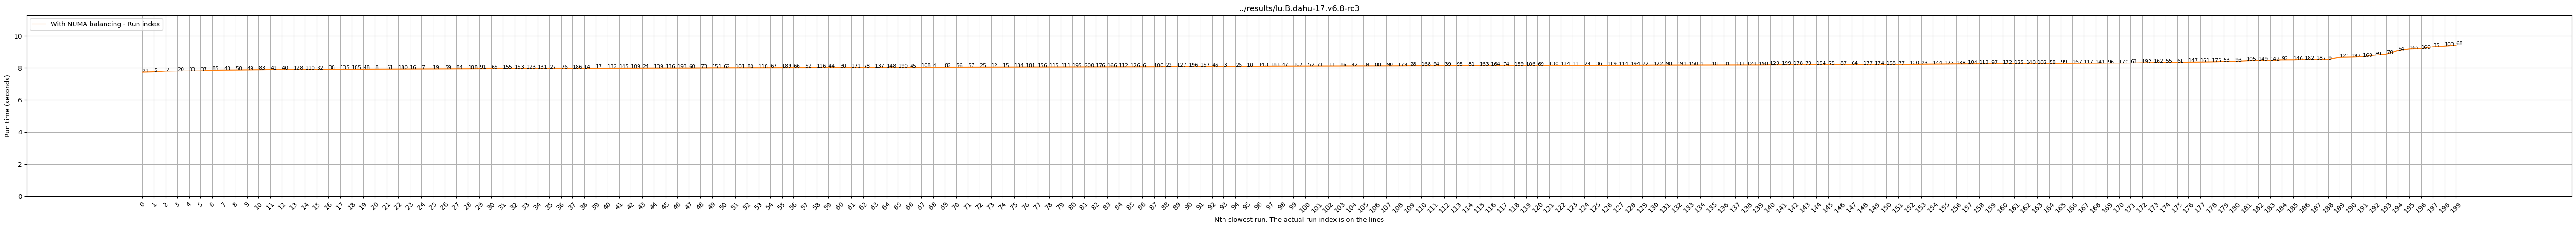

In [88]:
print_result_idx(14)

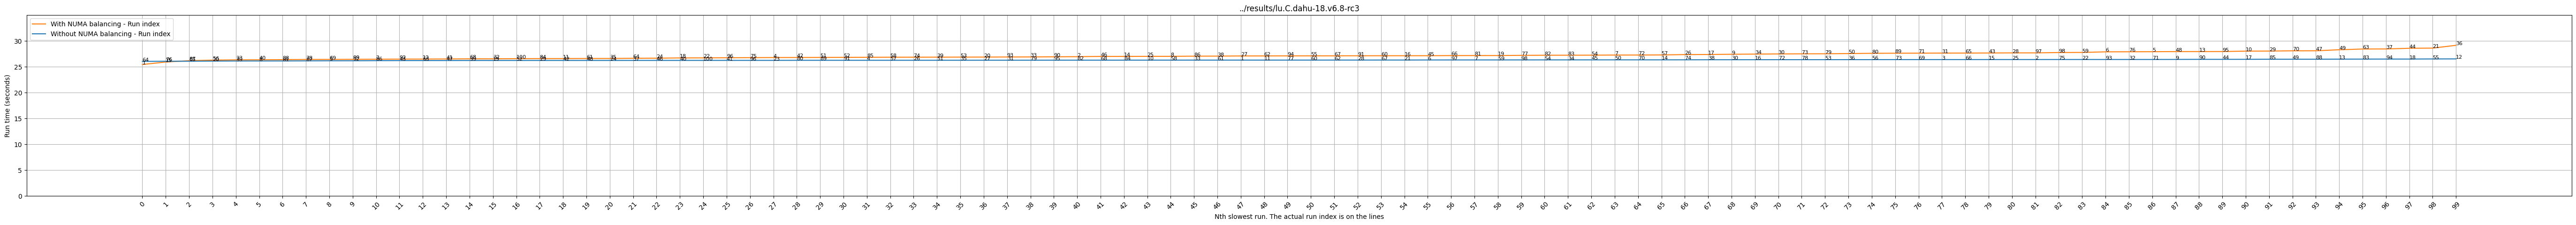

In [89]:
print_result_idx(15)

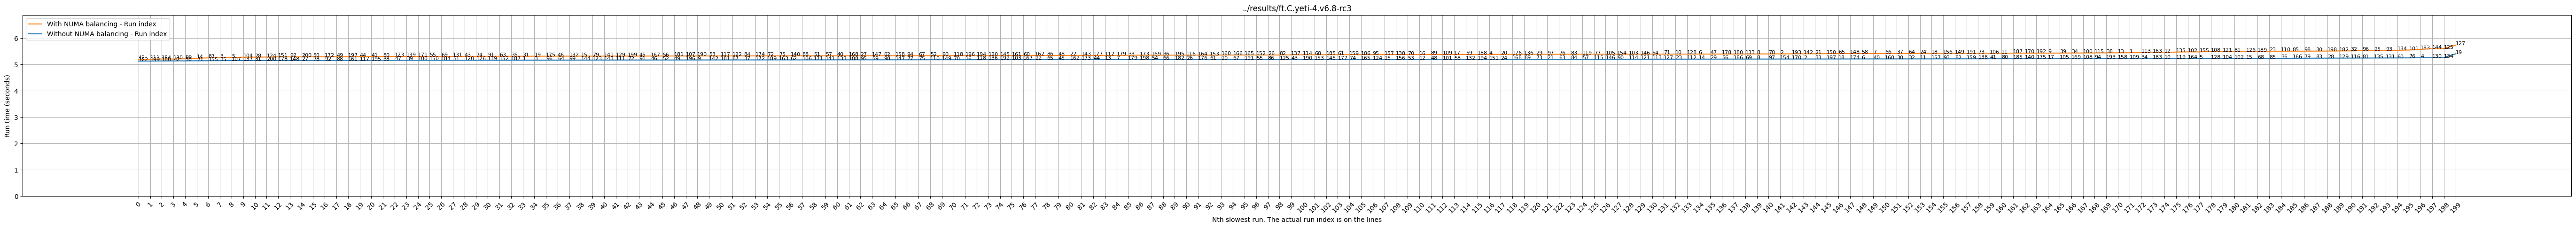

In [90]:
print_result_idx(11)

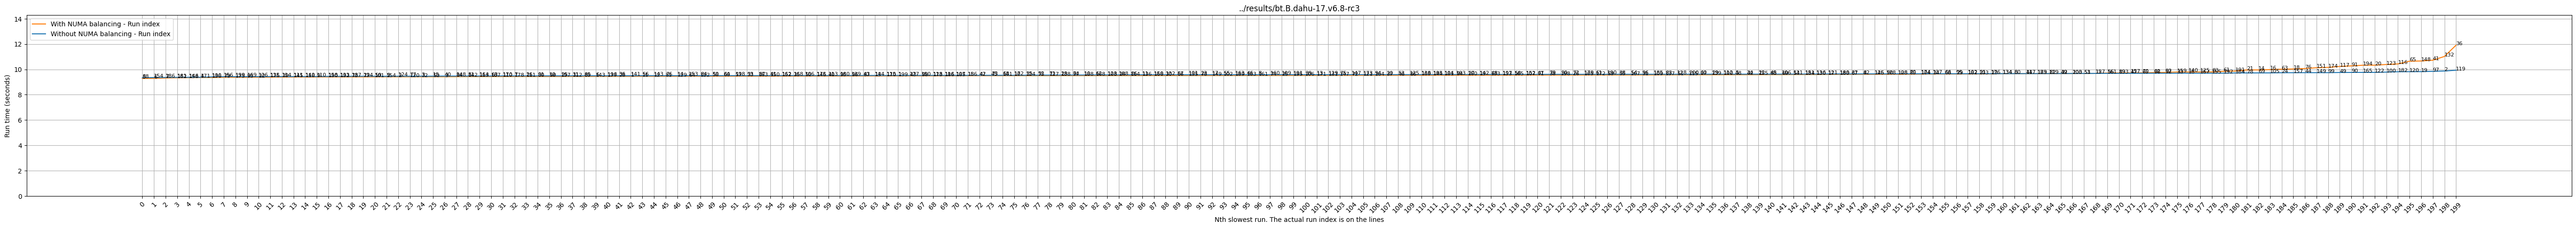

In [91]:
print_result_idx(0)

In [17]:
df = get_runtimes_dataframe("results/ft.C.yeti-1/nb")
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)

None